<a href="https://colab.research.google.com/github/eduardocdv/Dados_ONS/blob/main/Dados_ONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalações e importações

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.svm import SVR
import statsmodels.graphics.tsaplots as smt;
import statsmodels.api as sm

# Leitura dos dados

Fazendo a leitura dos arquivos. Cada arquivo foi convertido automaticamente por um script python executado localmente, que faz a varredura da pasta em que os arquivos .csv estão armazenados e salva no formato .parquet. Inicialmente se tinha 6GB em arquivos, após a conversão 315MB.

In [3]:
df00 = pd.read_parquet('/content/GERACAO_USINA_2000.parquet')
df01 = pd.read_parquet('/content/GERACAO_USINA_2001.parquet')
df02 = pd.read_parquet('/content/GERACAO_USINA_2002.parquet')
df03 = pd.read_parquet('/content/GERACAO_USINA_2003.parquet')
df04 = pd.read_parquet('/content/GERACAO_USINA_2004.parquet')
df05 = pd.read_parquet('/content/GERACAO_USINA_2005.parquet')
df06 = pd.read_parquet('/content/GERACAO_USINA_2006.parquet')
df07 = pd.read_parquet('/content/GERACAO_USINA_2007.parquet')
df08 = pd.read_parquet('/content/GERACAO_USINA_2008.parquet')
df09 = pd.read_parquet('/content/GERACAO_USINA_2009.parquet')
df10 = pd.read_parquet('/content/GERACAO_USINA_2010.parquet')
df11 = pd.read_parquet('/content/GERACAO_USINA_2011.parquet')
df12 = pd.read_parquet('/content/GERACAO_USINA_2012.parquet')
df13 = pd.read_parquet('/content/GERACAO_USINA_2013.parquet')
df14 = pd.read_parquet('/content/GERACAO_USINA_2014.parquet')
df15 = pd.read_parquet('/content/GERACAO_USINA_2015.parquet')
df16 = pd.read_parquet('/content/GERACAO_USINA_2016.parquet')
df17 = pd.read_parquet('/content/GERACAO_USINA_2017.parquet')
df18 = pd.read_parquet('/content/GERACAO_USINA_2018.parquet')
df19 = pd.read_parquet('/content/GERACAO_USINA_2019.parquet')
df20 = pd.read_parquet('/content/GERACAO_USINA_2020.parquet')

Criando índice datetime pra cada dataframe e remoção de colunas que não serão utilizadas.

In [4]:
dataframes = [df00, df01, df02, df03, df04, df05, df06, df07, df08, df09, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20]
for df in dataframes:
    df['din_instante'] = pd.to_datetime(df['din_instante'])
    df.set_index('din_instante', inplace=True)
    df.drop('ceg', axis = 1, inplace = True)
    df.drop('cod_modalidadeoperacao', axis = 1, inplace = True)

Concatenação e remoção de coluna 'id_ons'

In [5]:
geracao_final = pd.concat(dataframes)
geracao_final.drop('id_ons', axis=1, inplace = True)
geracao_final.to_parquet('geracao_final.parquet')

# Análise descritiva

In [6]:
geracao_final = pd.read_parquet('geracao_final.parquet')
geracao_final.index = pd.to_datetime(geracao_final.index)

Colunas que serão utilizadas na análise

In [7]:
geracao_final.columns

Index(['id_subsistema', 'nom_subsistema', 'id_estado', 'nom_estado',
       'nom_tipousina', 'nom_tipocombustivel', 'nom_usina', 'val_geracao'],
      dtype='object')

 O Sistema Interligado Nacional é constituído por quatro subsistemas: Sul, Sudeste/Centro-Oeste, Nordeste e a maior parte da região Norte.

In [8]:
geracao_final['id_subsistema'].unique()

array(['N', 'NE', 'S', 'SE'], dtype=object)

Tipos de fontes presentes

In [9]:
geracao_final['nom_tipocombustivel'].unique()

array(['Hidráulica', 'Gás', 'Carvão', 'Biomassa', 'Óleo Combustível',
       'Nuclear', 'Óleo Diesel', 'Eólica', 'Resíduos Industriais',
       'Fotovoltaica'], dtype=object)

In [10]:
geracao_final['nom_estado'].unique()

array(['PARA', 'ALAGOAS', 'BAHIA', 'PERNAMBUCO', 'PIAUI', 'PARANA',
       'RIO GRANDE DO SUL', 'SANTA CATARINA', 'DISTRITO FEDERAL',
       'ESPIRITO SANTO', 'GOIAS', 'z - INTERNACIONAL', 'MINAS GERAIS',
       'MATO GROSSO DO SUL', 'MATO GROSSO', 'RIO DE JANEIRO', 'SAO PAULO',
       'TOCANTINS', 'CEARA', 'PARAIBA', 'RIO GRANDE DO NORTE', 'SERGIPE',
       'RONDONIA', 'ACRE', 'MARANHAO', 'AMAZONAS', 'AMAPA'], dtype=object)

In [11]:
geracao_final['id_estado'].unique()

array(['PA', 'AL', 'BA', 'PE', 'PI', 'PR', 'RS', 'SC', 'DF', 'ES', 'GO',
       'I', 'MG', 'MS', 'MT', 'RJ', 'SP', 'TO', 'CE', 'PB', 'RN', 'SE',
       'RO', 'AC', 'MA', 'AM', 'AP'], dtype=object)

Até 2019, o estado de Roraima não estava sob supervisão da ONS, então foram atribuídos os nomes 'z - INTERNACIONAL' ao estado e 'I' à sigla. Por isso, o estado será removido da análise.


In [12]:
geracao_final = geracao_final[geracao_final['id_estado'] != 'I']

Verificando se há dados ausentes

<Axes: ylabel='din_instante'>

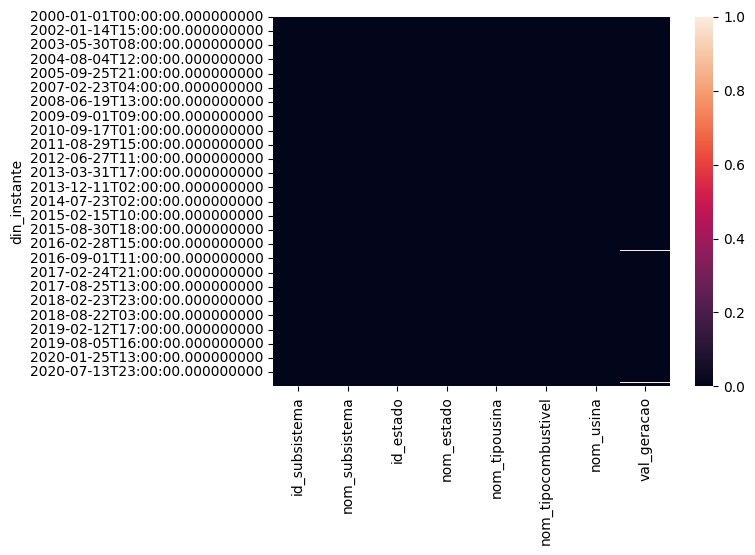

In [ ]:
sns.heatmap(geracao_final.isna()) #não executar mais

Exibindo as linhas que contém NaN


In [13]:
linhas_nan = geracao_final[geracao_final['val_geracao'].isna()]
print(linhas_nan)

                    id_subsistema nom_subsistema id_estado      nom_estado  \
din_instante                                                                 
2004-02-15 00:00:00            SE        SUDESTE        SP       SAO PAULO   
2004-02-15 01:00:00            SE        SUDESTE        SP       SAO PAULO   
2004-02-15 02:00:00            SE        SUDESTE        SP       SAO PAULO   
2004-02-15 03:00:00            SE        SUDESTE        SP       SAO PAULO   
2004-02-15 04:00:00            SE        SUDESTE        SP       SAO PAULO   
...                           ...            ...       ...             ...   
2020-12-31 19:00:00            SE        SUDESTE        RJ  RIO DE JANEIRO   
2020-12-31 20:00:00            SE        SUDESTE        RJ  RIO DE JANEIRO   
2020-12-31 21:00:00            SE        SUDESTE        RJ  RIO DE JANEIRO   
2020-12-31 22:00:00            SE        SUDESTE        RJ  RIO DE JANEIRO   
2020-12-31 23:00:00            SE        SUDESTE        RJ  RIO 

Remoção dos dados ausentes

In [14]:
geracao_final = geracao_final.dropna()

Describe da geração

In [15]:
geracao_final['val_geracao'].describe()

count    5.398727e+07
mean     1.657720e+02
std      4.718586e+02
min      0.000000e+00
25%      0.000000e+00
50%      3.375800e+01
75%      1.229740e+02
max      1.070580e+04
Name: val_geracao, dtype: float64

Plotando os gráficos

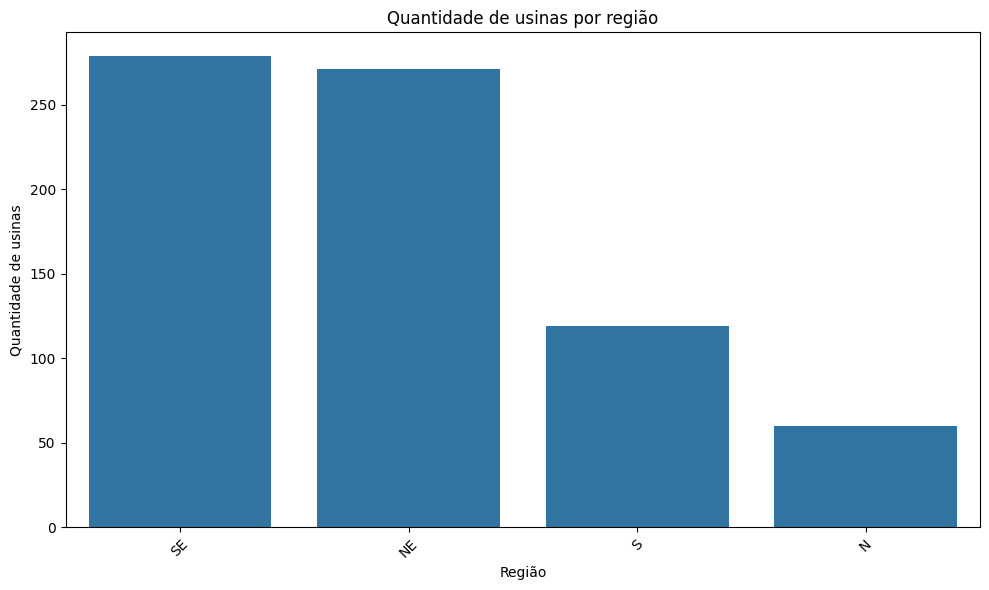

In [16]:
usinas_unicas_por_regiao = geracao_final.drop_duplicates(subset=['nom_usina', 'id_subsistema'])
contagem_usinas_unicas_por_regiao = usinas_unicas_por_regiao['id_subsistema'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=contagem_usinas_unicas_por_regiao.index, y=contagem_usinas_unicas_por_regiao.values)
plt.title('Quantidade de usinas por região')
plt.xlabel('Região')
plt.ylabel('Quantidade de usinas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


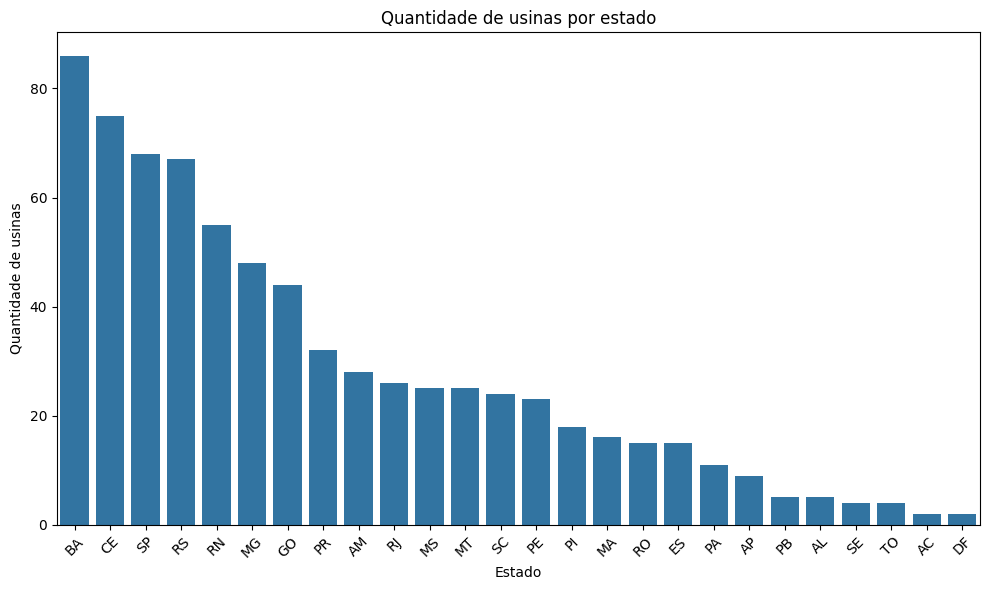

In [17]:
usinas_unicas_por_regiao = geracao_final.drop_duplicates(subset=['nom_usina', 'id_estado'])
contagem_usinas_unicas_por_regiao = usinas_unicas_por_regiao['id_estado'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=contagem_usinas_unicas_por_regiao.index, y=contagem_usinas_unicas_por_regiao.values)
plt.title('Quantidade de usinas por estado')
plt.xlabel('Estado')
plt.ylabel('Quantidade de usinas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-18-c9908cc4a3a8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=qtd_geracao_por_estado.index, y=qtd_geracao_por_estado.values, palette='viridis')


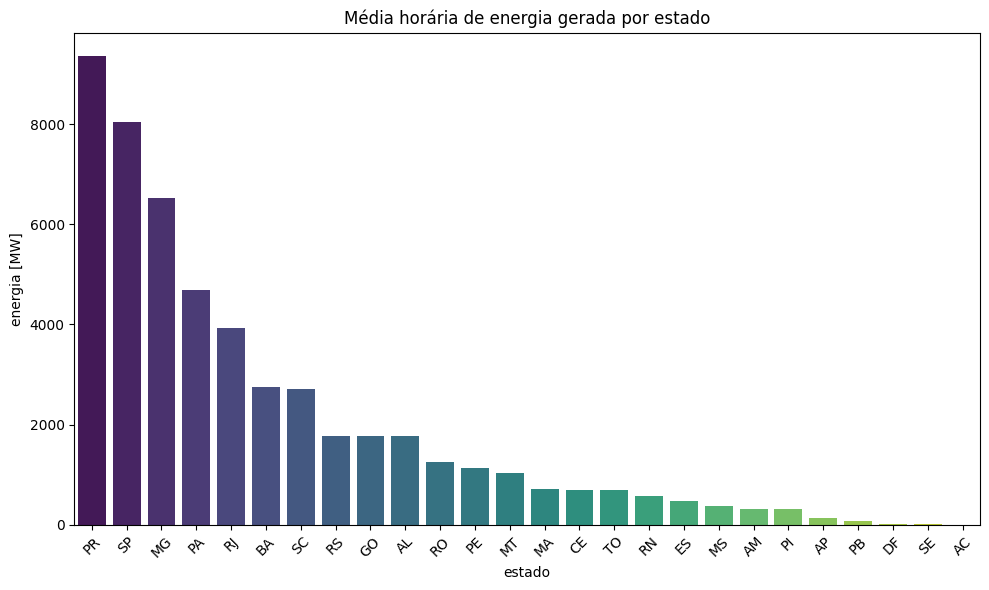

In [18]:
qtd_geracao_por_estado = geracao_final.groupby('id_estado')['val_geracao'].sum().sort_values(ascending=False)
qtd_geracao_por_estado = qtd_geracao_por_estado/175200 #quantidade de horas em 20 anos
plt.figure(figsize=(10, 6))
sns.barplot(x=qtd_geracao_por_estado.index, y=qtd_geracao_por_estado.values, palette='viridis')
plt.title('Média horária de energia gerada por estado')
plt.xlabel('estado')
plt.ylabel('energia [MW]')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-19-829f6645853a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=qtd_geracao_por_regiao.index, y=qtd_geracao_por_regiao.values, palette='viridis')


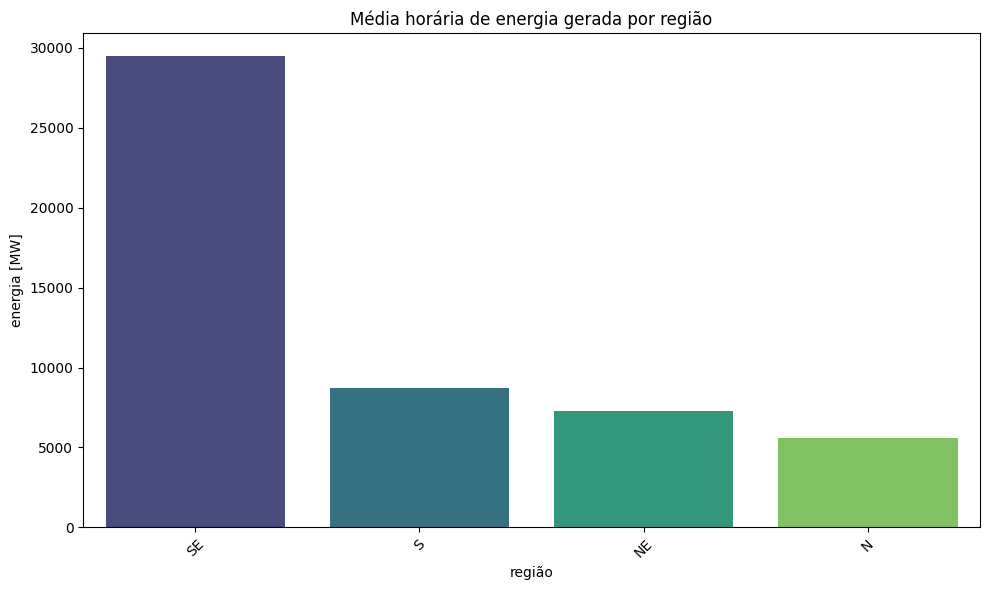

In [19]:
qtd_geracao_por_regiao = geracao_final.groupby('id_subsistema')['val_geracao'].sum().sort_values(ascending=False)
qtd_geracao_por_regiao = qtd_geracao_por_regiao/175200
plt.figure(figsize=(10, 6))
sns.barplot(x=qtd_geracao_por_regiao.index, y=qtd_geracao_por_regiao.values, palette='viridis')
plt.title('Média horária de energia gerada por região')
plt.xlabel('região')
plt.ylabel('energia [MW]')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

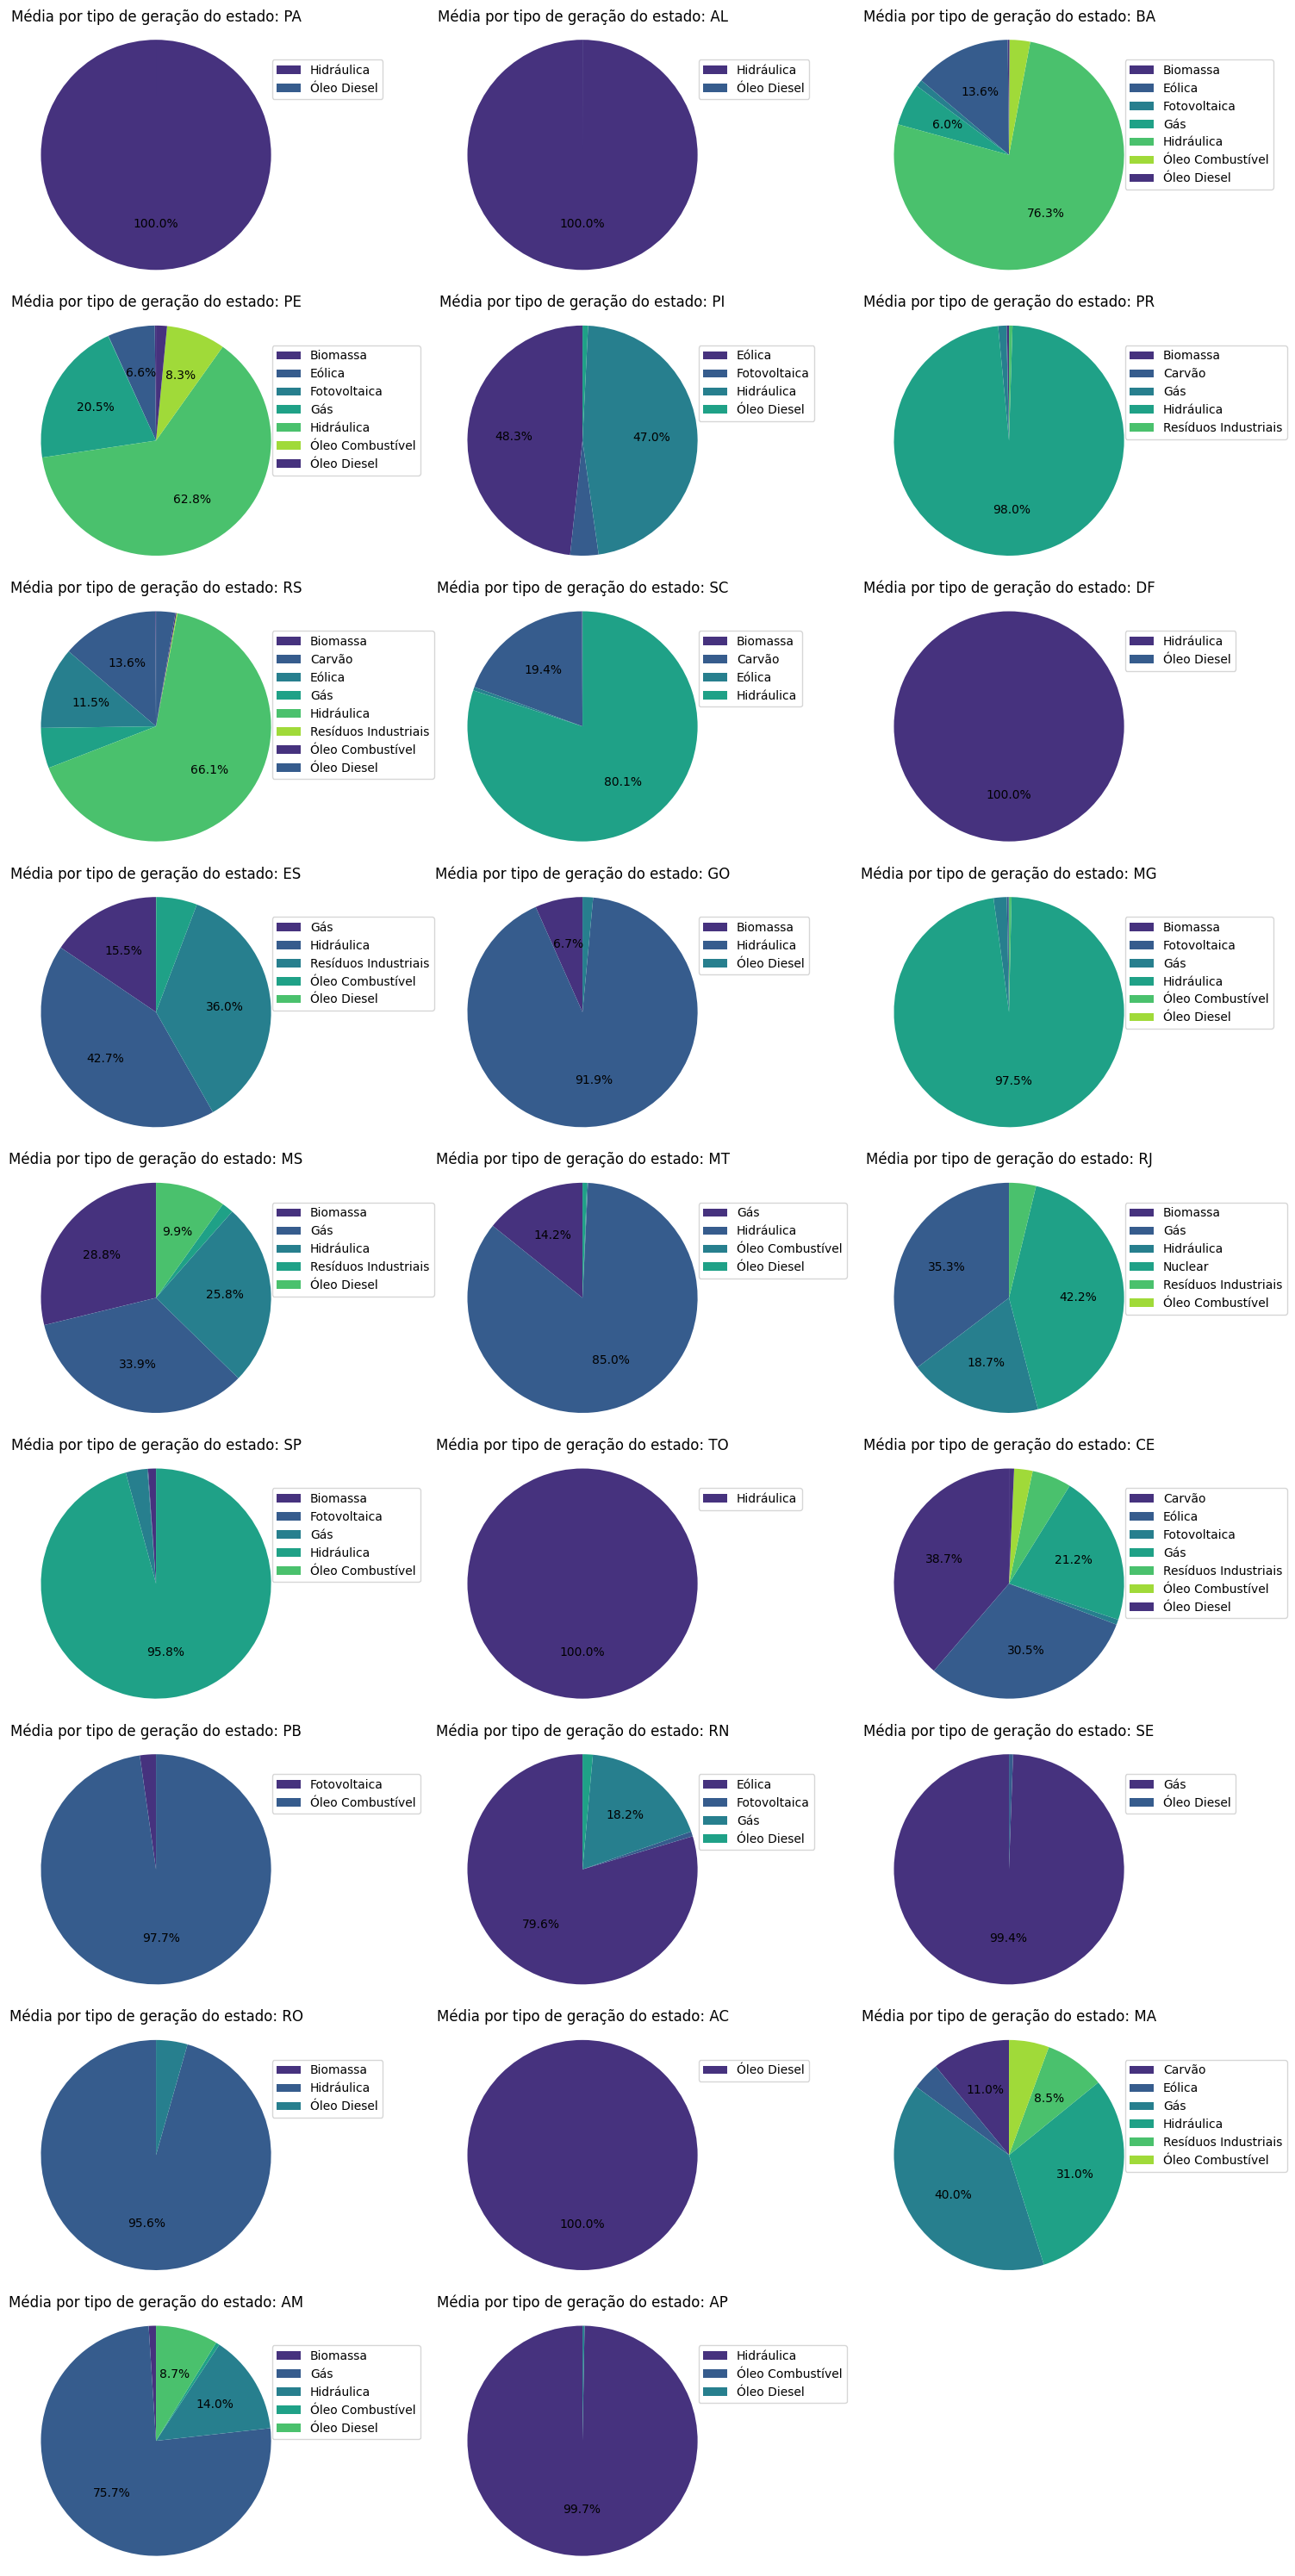

In [20]:
viridis_palette = sns.color_palette("viridis")
siglas_estados = geracao_final['id_estado'].unique()

fig, axs = plt.subplots(9, 3, figsize=(15, 30))
axs = axs.flatten()

for i, sigla_estado in enumerate(siglas_estados):

    df_estado = geracao_final[geracao_final['id_estado'] == sigla_estado]
    total_por_tipo_usina = df_estado.groupby('nom_tipocombustivel')['val_geracao'].sum()/175200
    patches, texts, autotexts = axs[i].pie(total_por_tipo_usina, startangle=90, autopct='%1.1f%%', colors=viridis_palette)
    axs[i].set_title(f'Média por tipo de geração do estado: {sigla_estado}')
    axs[i].set_ylabel('')
    axs[i].axis('equal')
    for autotext in autotexts:
        autotext.set_visible(float(autotext.get_text().strip('%')) >= 6)
    axs[i].legend(total_por_tipo_usina.index, loc='upper left', bbox_to_anchor=(0.9, 0.9))
axs[-1].axis('off')
plt.tight_layout()
plt.show()

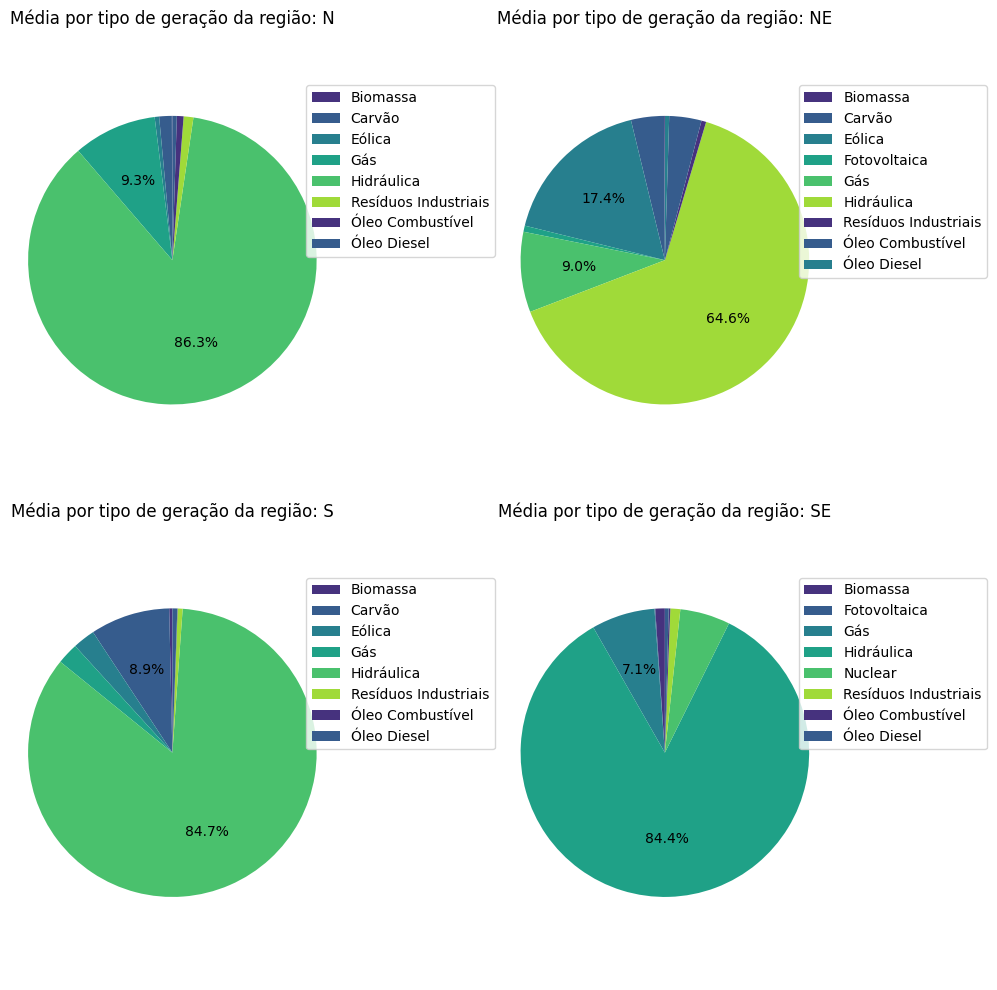

In [21]:
viridis_palette = sns.color_palette("viridis")
siglas_regioes = geracao_final['id_subsistema'].unique()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i, sigla_regiao in enumerate(siglas_regioes):

    df_regiao = geracao_final[geracao_final['id_subsistema'] == sigla_regiao]
    total_por_tipo_usina = df_regiao.groupby('nom_tipocombustivel')['val_geracao'].sum()/175200
    patches, texts, autotexts = axs[i].pie(total_por_tipo_usina, startangle=90, autopct='%1.1f%%', colors=viridis_palette)
    axs[i].set_title(f'Média por tipo de geração da região: {sigla_regiao}')
    axs[i].set_ylabel('')
    axs[i].axis('equal')
    for autotext in autotexts:
        autotext.set_visible(float(autotext.get_text().strip('%')) >= 6)
    axs[i].legend(total_por_tipo_usina.index, loc='upper left', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

<ipython-input-209-a8c6ed480879>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_media_mensal = df_estado.groupby(['nom_tipocombustivel', df_estado.index.month]).sum()/720;
<ipython-input-209-a8c6ed480879>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
<ipython-input-209-a8c6ed480879>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_media_mensal = df_estado.groupby(['nom_tipocombustivel', df_estado.index.month]).sum()/720;
<ipython-input-209-a8c6ed480879>:26: UserWarning: FixedFormatter should only be used

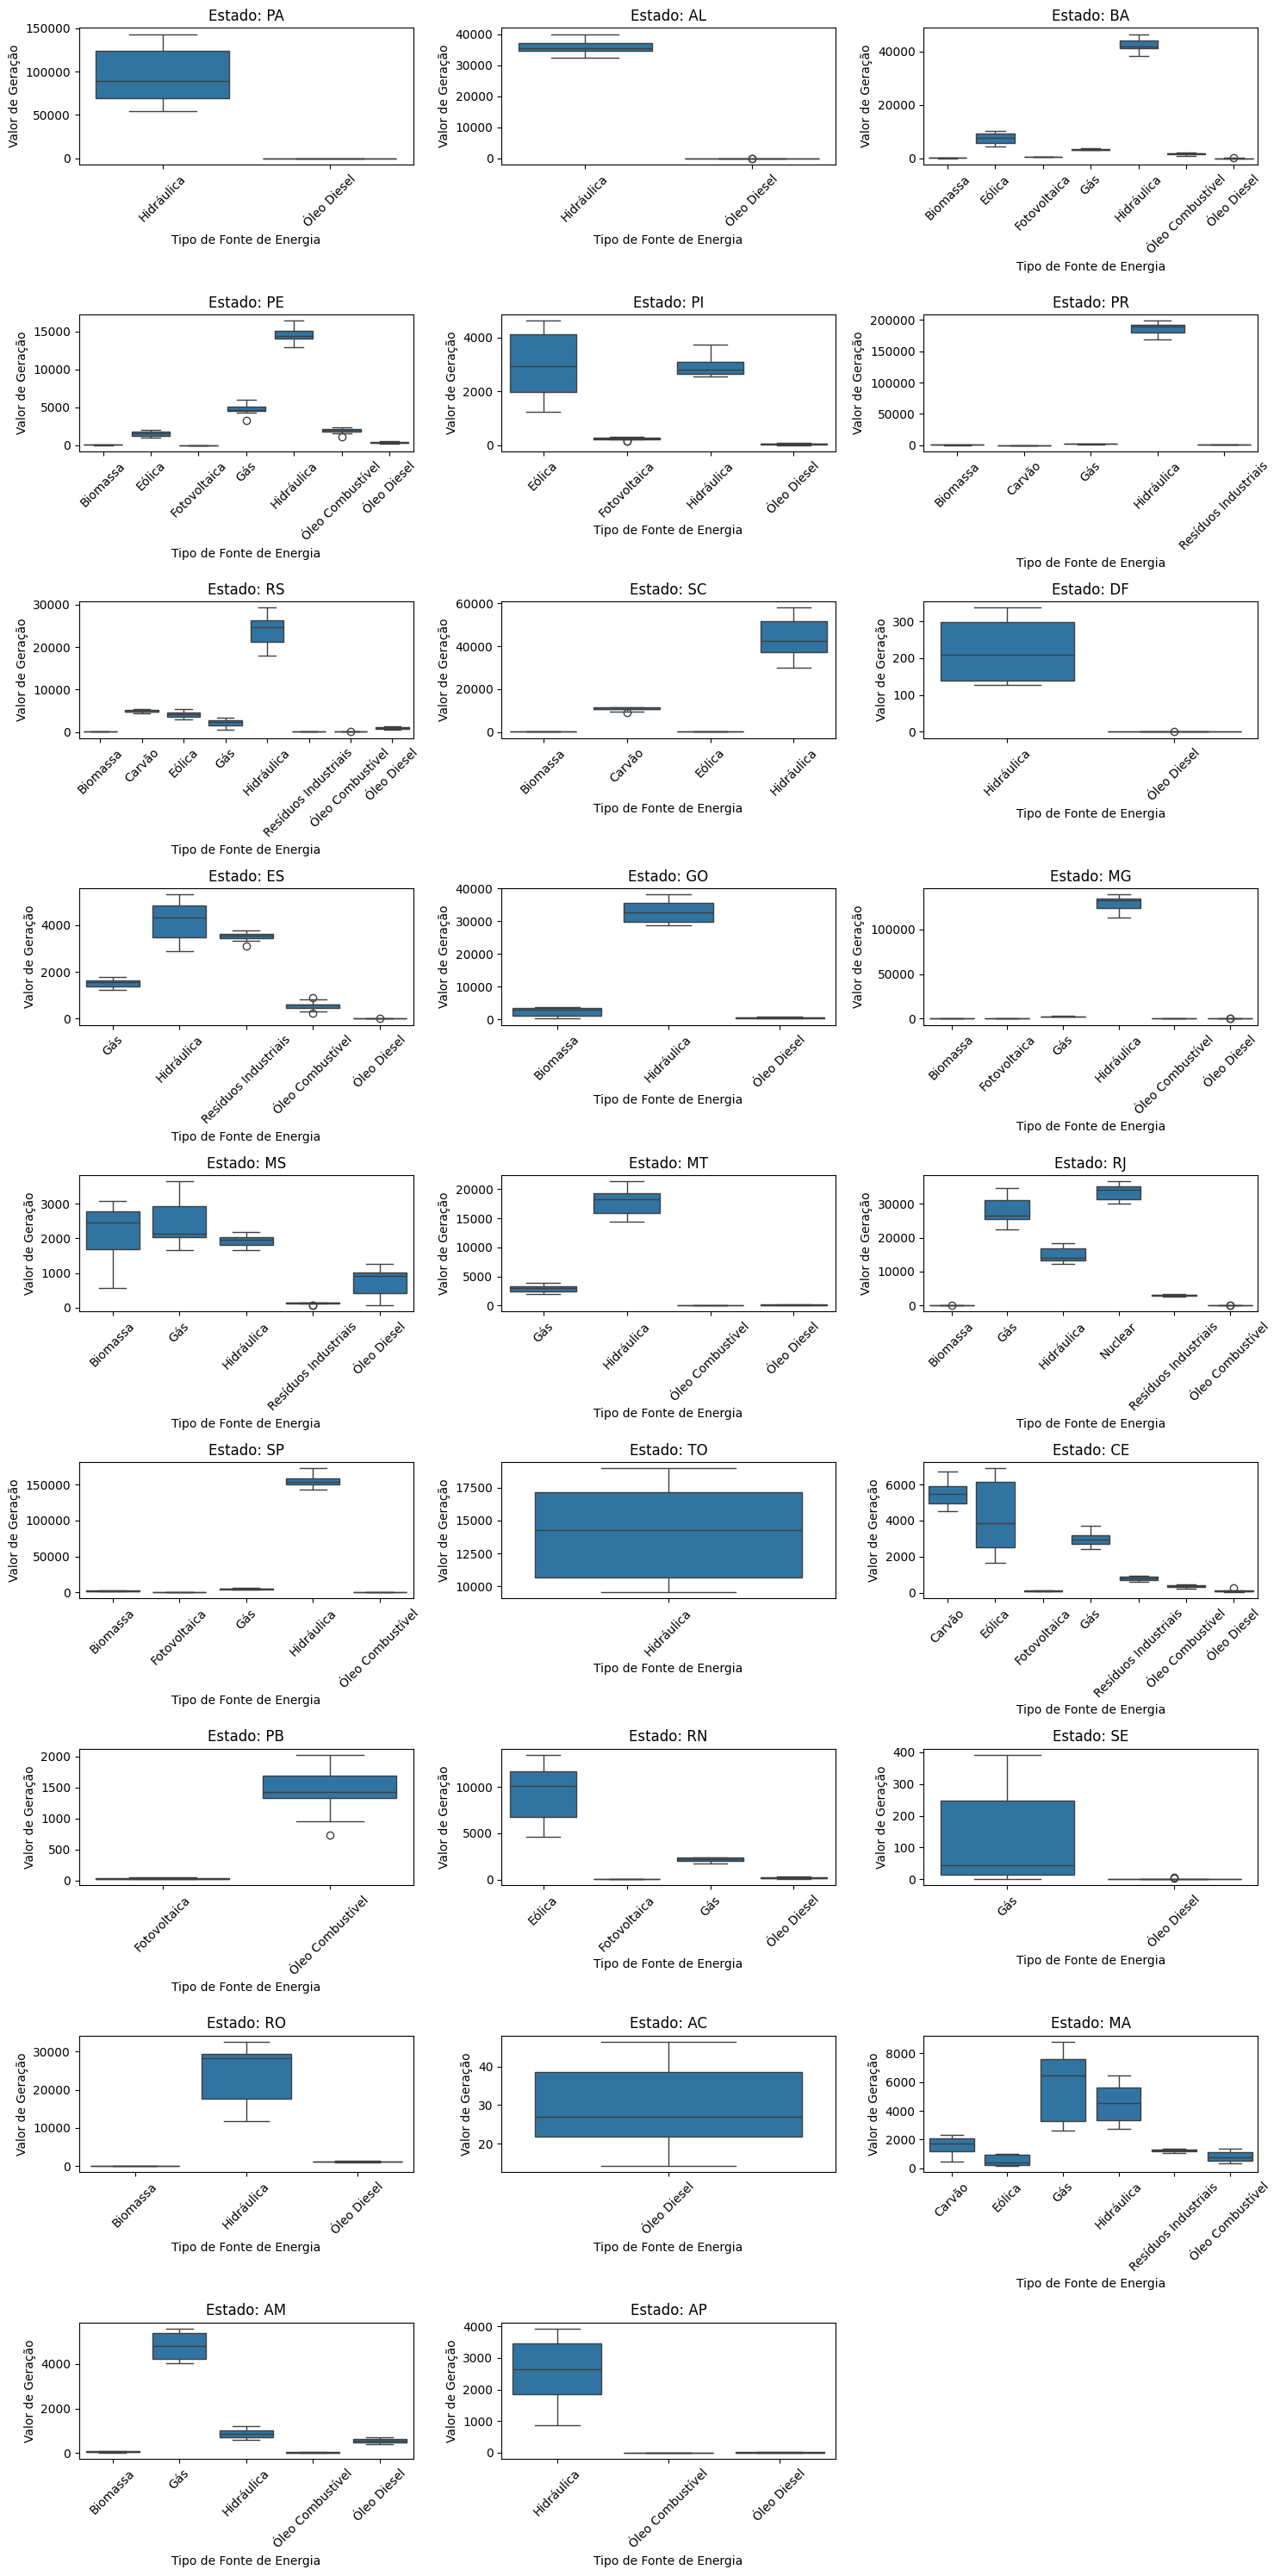

In [ ]:
estados = geracao_final['id_estado'].unique()

# Configuração do loop
num_linhas = 9
num_colunas = 3
num_graficos = num_linhas * num_colunas

# Divisão dos estados em lotes de tamanho num_graficos
batches = [estados[i:i+num_graficos] for i in range(0, len(estados), num_graficos)]

# Loop sobre os lotes de estados
for batch in batches:
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(15, 30))
    axs = axs.flatten()

    # Loop sobre cada estado no lote atual
    for i, estado in enumerate(batch):
        df_estado = geracao_final[geracao_final['id_estado'] == estado]
        df_media_mensal = df_estado.groupby(['nom_tipocombustivel', df_estado.index.month]).sum()/720;
        df_media_mensal.reset_index(inplace=True)

        sns.boxplot(data=df_media_mensal, x='nom_tipocombustivel', y='val_geracao', ax=axs[i])
        axs[i].set_title(f'Estado: {estado}')
        axs[i].set_xlabel('Tipo de Fonte de Energia')
        axs[i].set_ylabel('Valor de Geração')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
    axs[-1].axis('off')
    plt.tight_layout()
    plt.show()

<ipython-input-210-caaea07a13b6>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_media_mensal = df_regiao.groupby(['nom_tipocombustivel', df_regiao.index.month]).sum()/720
<ipython-input-210-caaea07a13b6>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
<ipython-input-210-caaea07a13b6>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_media_mensal = df_regiao.groupby(['nom_tipocombustivel', df_regiao.index.month]).sum()/720
<ipython-input-210-caaea07a13b6>:22: UserWarning: FixedFormatter should only be used t

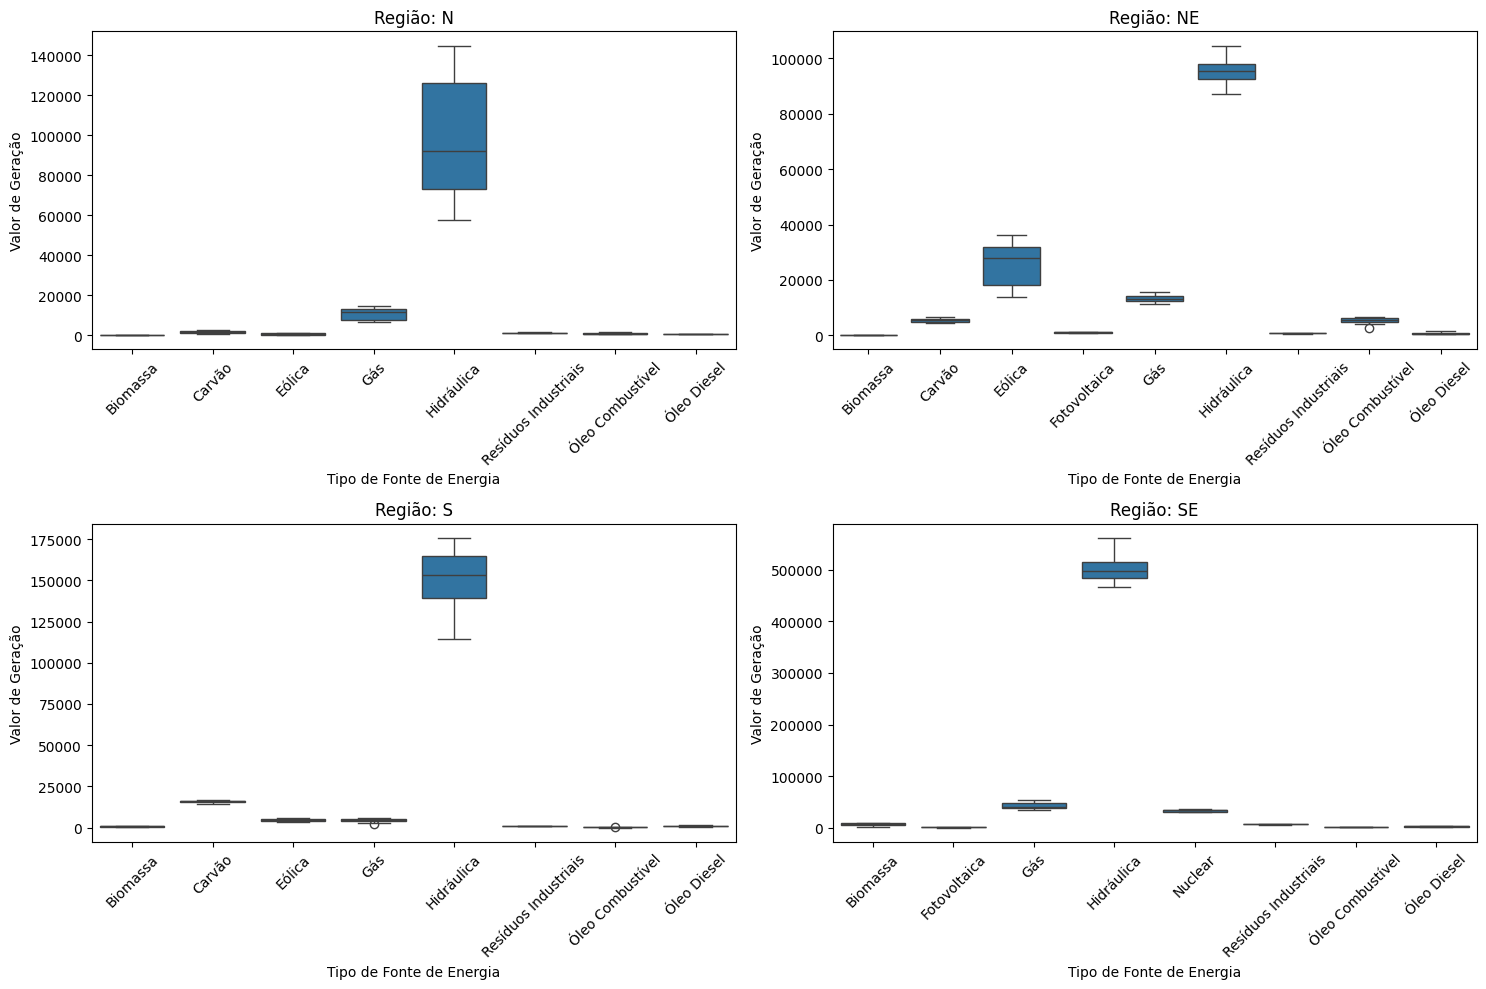

In [ ]:
regioes = geracao_final['id_subsistema'].unique()
num_linhas = 2
num_colunas = 2
num_graficos = num_linhas * num_colunas


batches = [regioes[i:i+num_graficos] for i in range(0, len(regioes), num_graficos)]

for batch in batches:
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(15, 10))
    axs = axs.flatten()

    for i, regiao in enumerate(batch):
        df_regiao = geracao_final[geracao_final['id_subsistema'] == regiao]
        df_media_mensal = df_regiao.groupby(['nom_tipocombustivel', df_regiao.index.month]).sum()/720
        df_media_mensal.reset_index(inplace=True)

        sns.boxplot(data=df_media_mensal, x='nom_tipocombustivel', y='val_geracao', ax=axs[i])
        axs[i].set_title(f'Região: {regiao}')
        axs[i].set_xlabel('Tipo de Fonte de Energia')
        axs[i].set_ylabel('Valor de Geração')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()


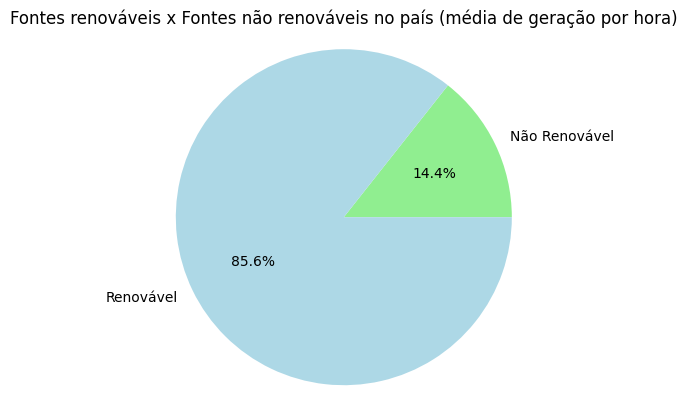

In [ ]:
copia = geracao_final.copy()
categoria_fonte_energia = {
    'Hidráulica': 'Renovável',
    'Biomassa': 'Renovável',
    'Eólica': 'Renovável',
    'Fotovoltaica': 'Renovável',
    'Gás': 'Não Renovável',
    'Carvão': 'Não Renovável',
    'Óleo Combustível': 'Não Renovável',
    'Nuclear': 'Não Renovável',
    'Óleo Diesel': 'Não Renovável',
    'Resíduos Industriais': 'Não Renovável'
}

copia['categoria'] = copia['nom_tipocombustivel'].map(categoria_fonte_energia)

total_por_categoria = copia.groupby('categoria')['val_geracao'].sum()/175200

total_por_categoria.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightblue'])
plt.title('Fontes renováveis x Fontes não renováveis no país (média de geração por hora)')
plt.ylabel('')
plt.legend().remove()
plt.axis('equal')
plt.show()


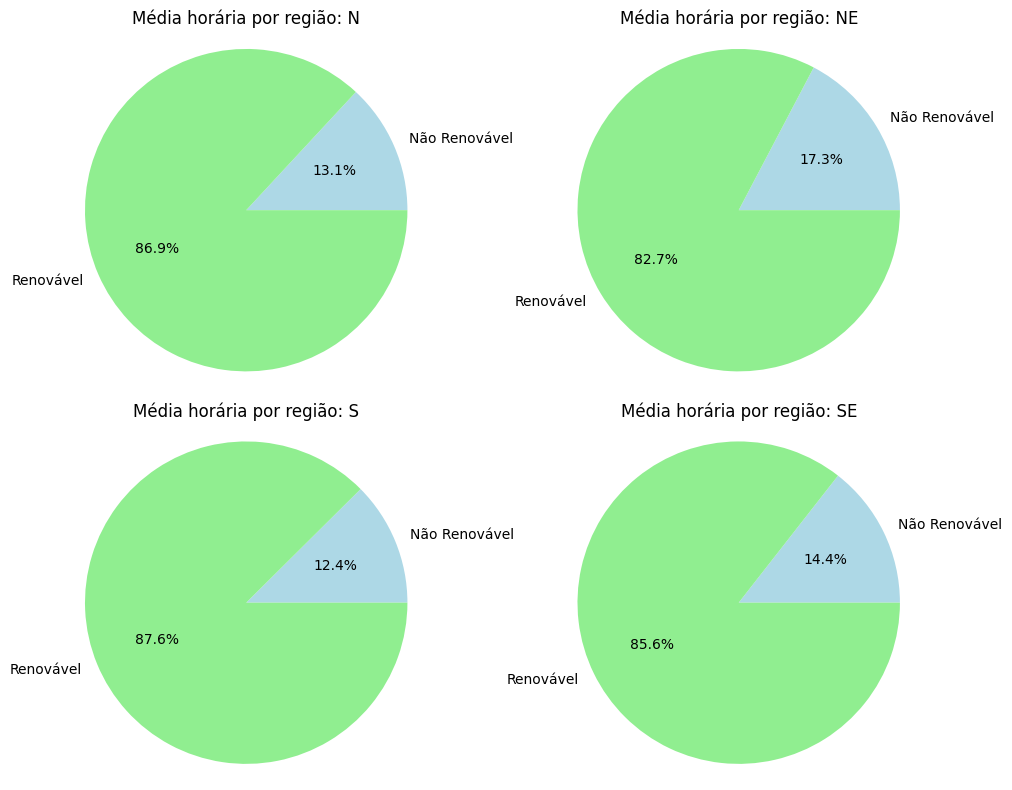

In [ ]:
cores = {
    'Renovável': 'lightgreen',
    'Não Renovável': 'lightblue'
}

total_por_regiao_categoria = copia.groupby(['id_subsistema', 'categoria'])['val_geracao'].sum()/175200
regioes = copia['id_subsistema'].unique()

num_linhas = 2
num_colunas = 2

fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 8))

for i, regiao in enumerate(regioes):
    linha = i // num_colunas
    coluna = i % num_colunas

    df_regiao = total_por_regiao_categoria.loc[regiao]
    ax = axs[linha, coluna]

    df_regiao.plot(kind='pie', autopct='%1.1f%%', colors=[cores[categoria] for categoria in df_regiao.index.get_level_values('categoria')], ax=ax)
    ax.set_title(f'Média horária por região: {regiao}')
    ax.set_ylabel('')
    ax.legend().remove()
    ax.axis('equal')

plt.tight_layout()
plt.show()



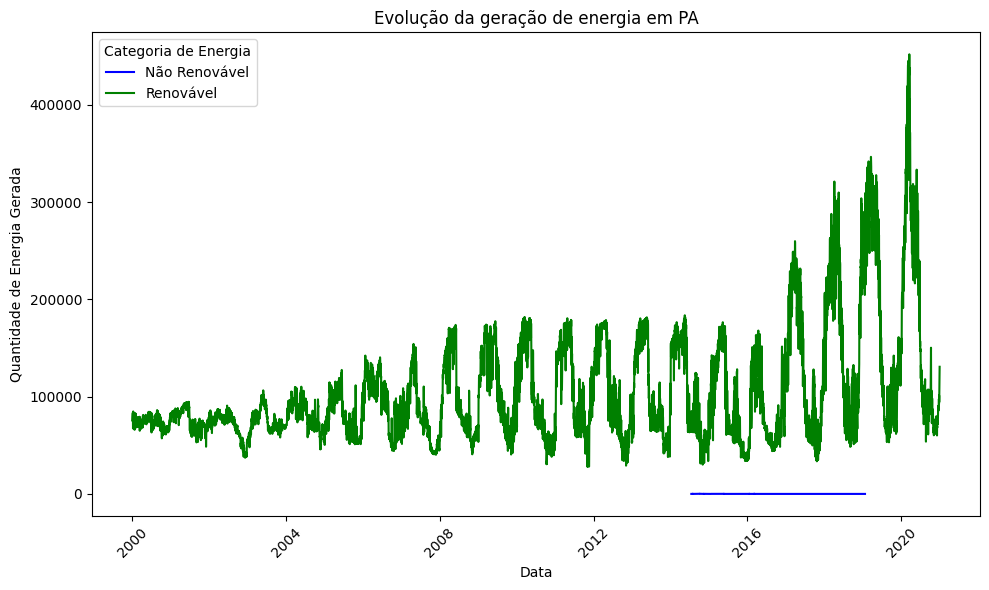

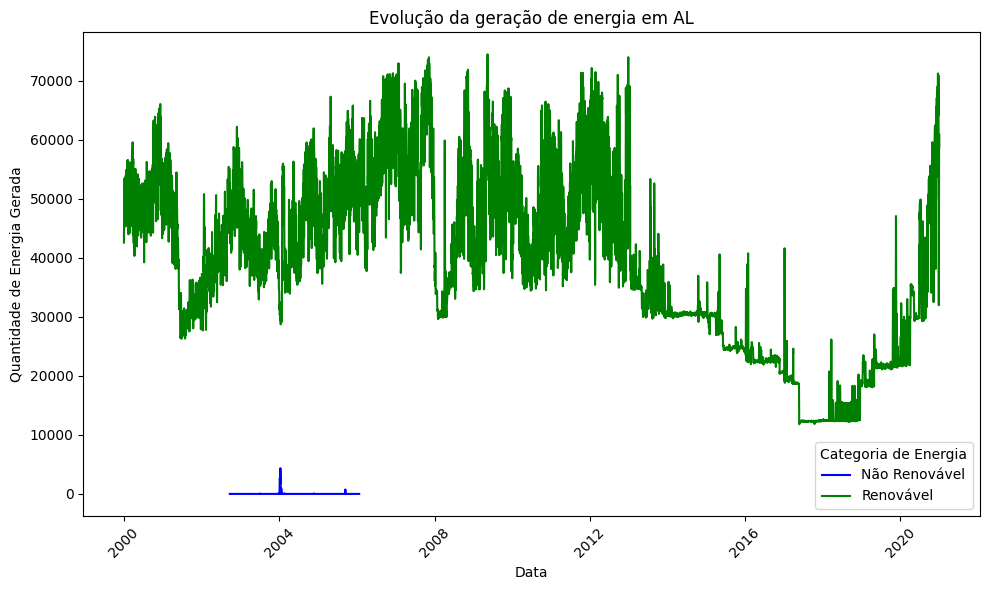

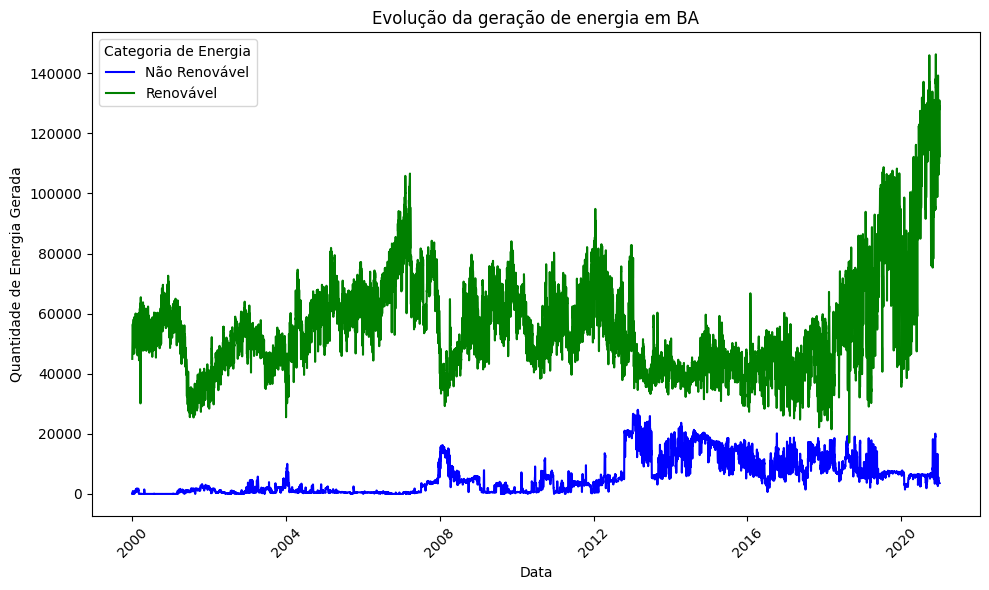

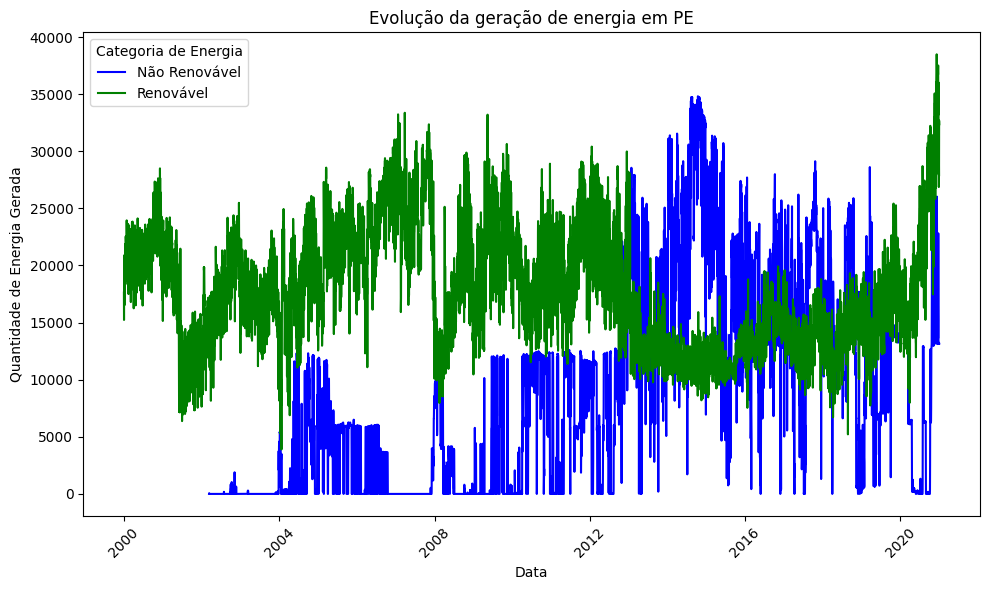

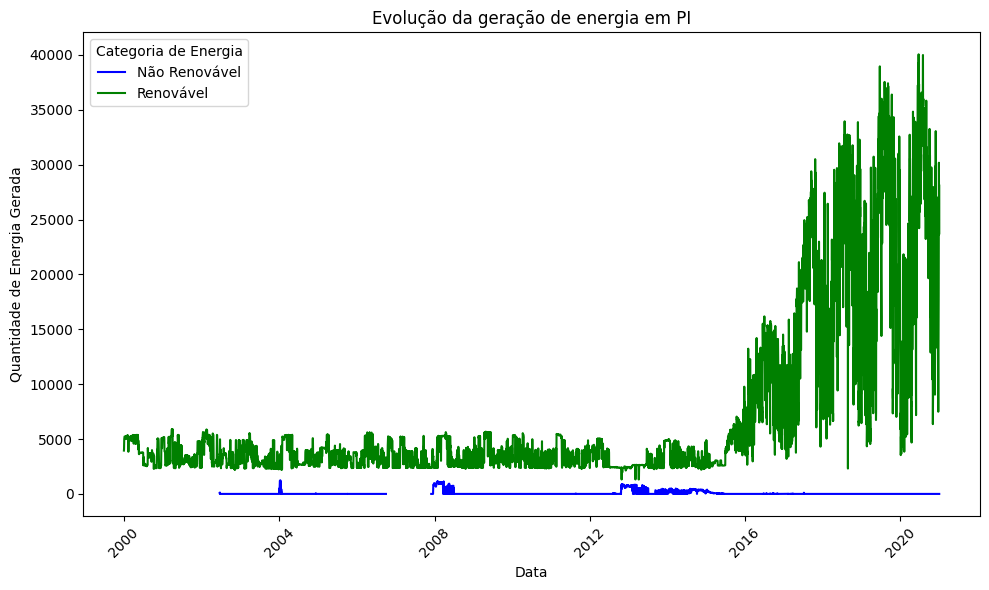

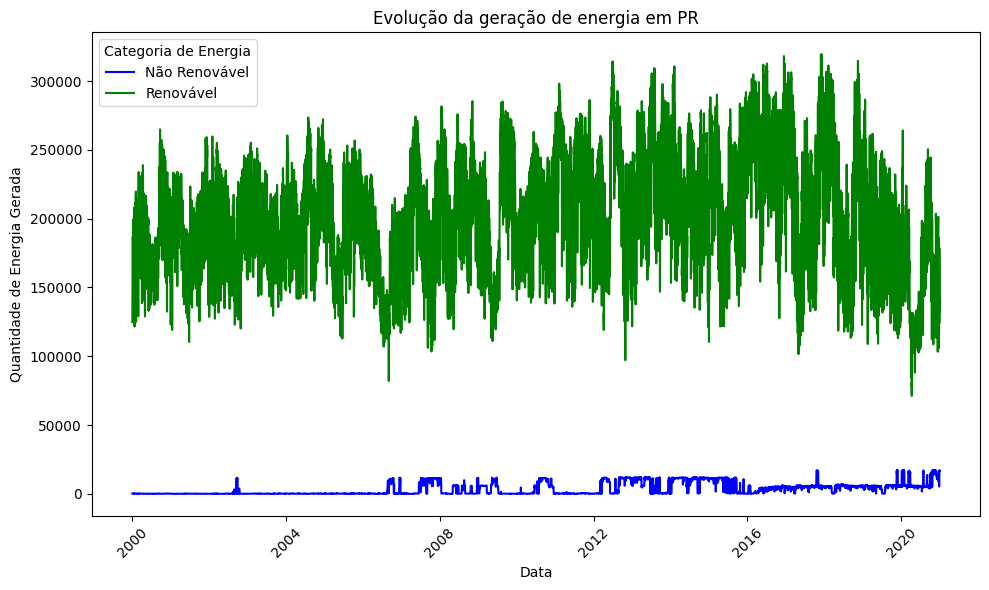

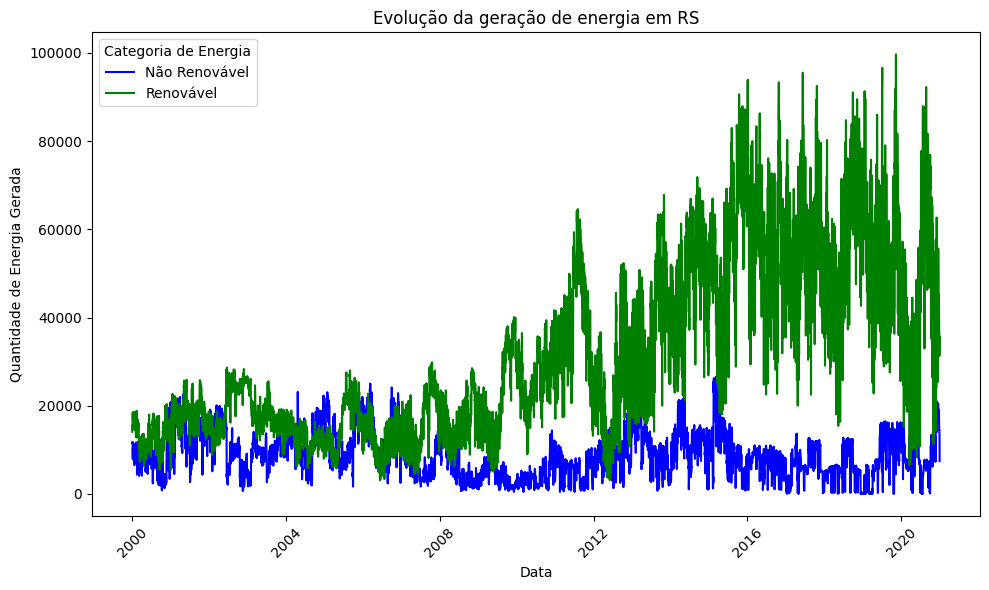

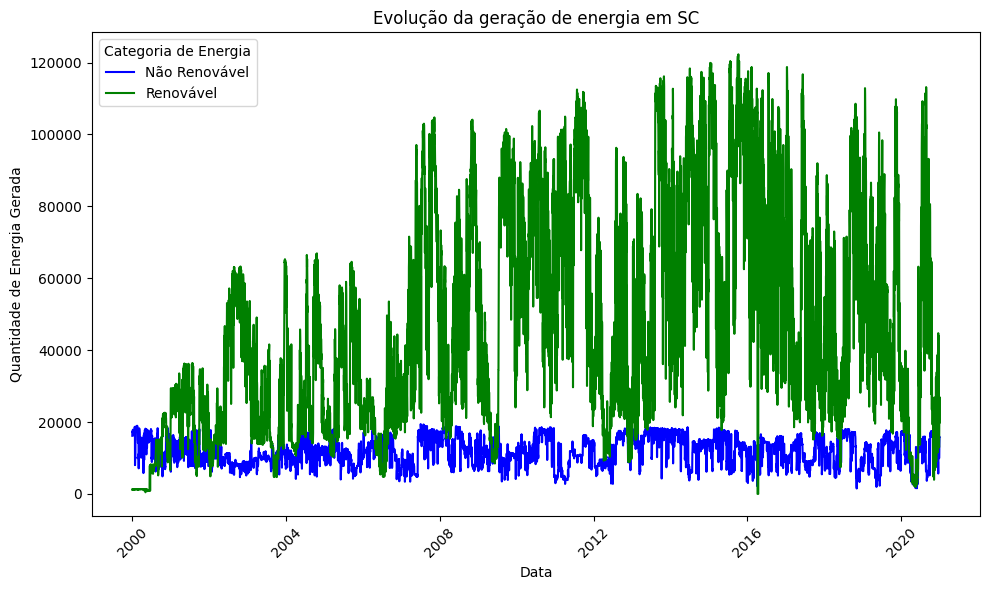

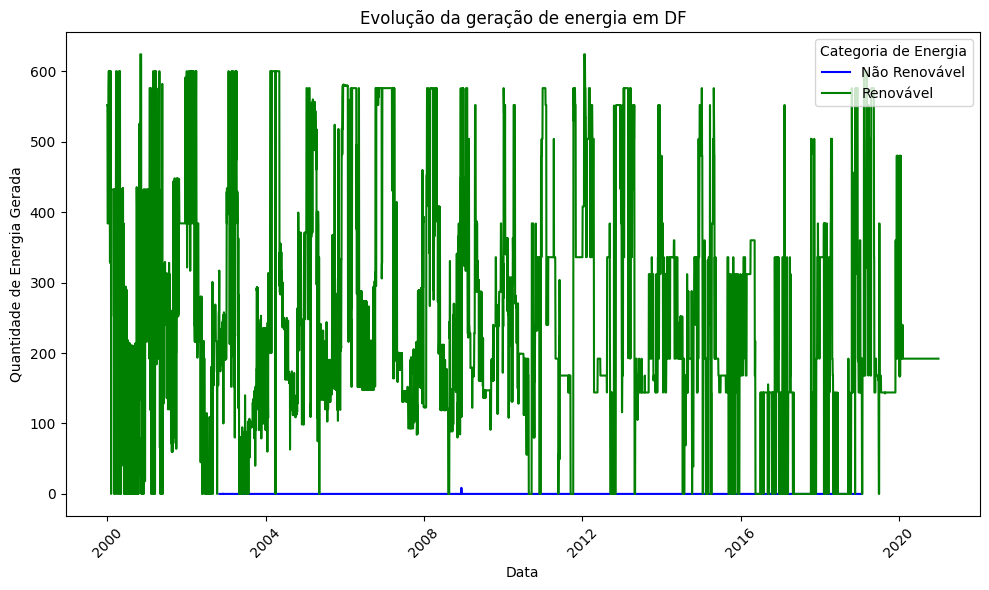

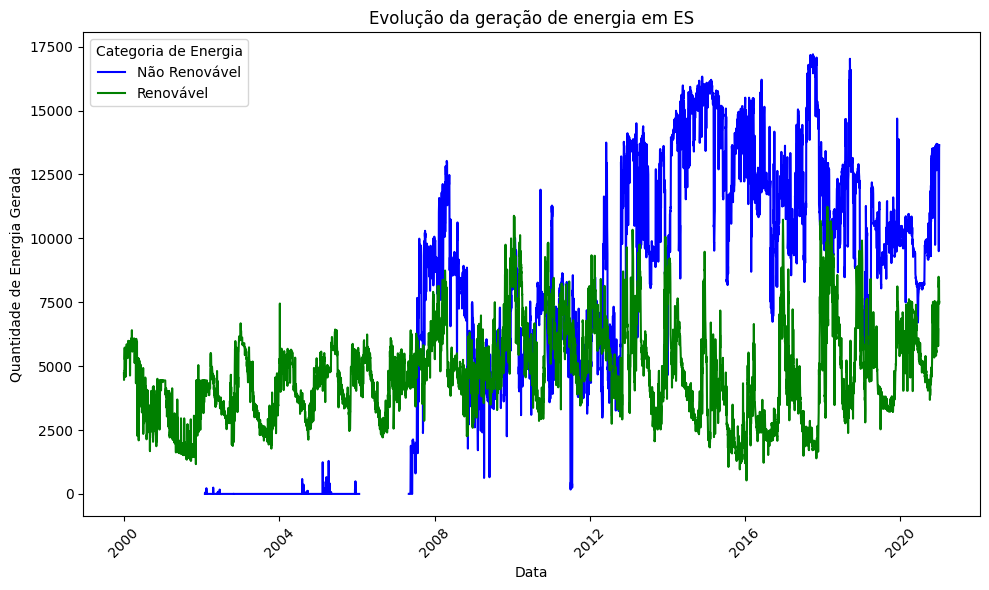

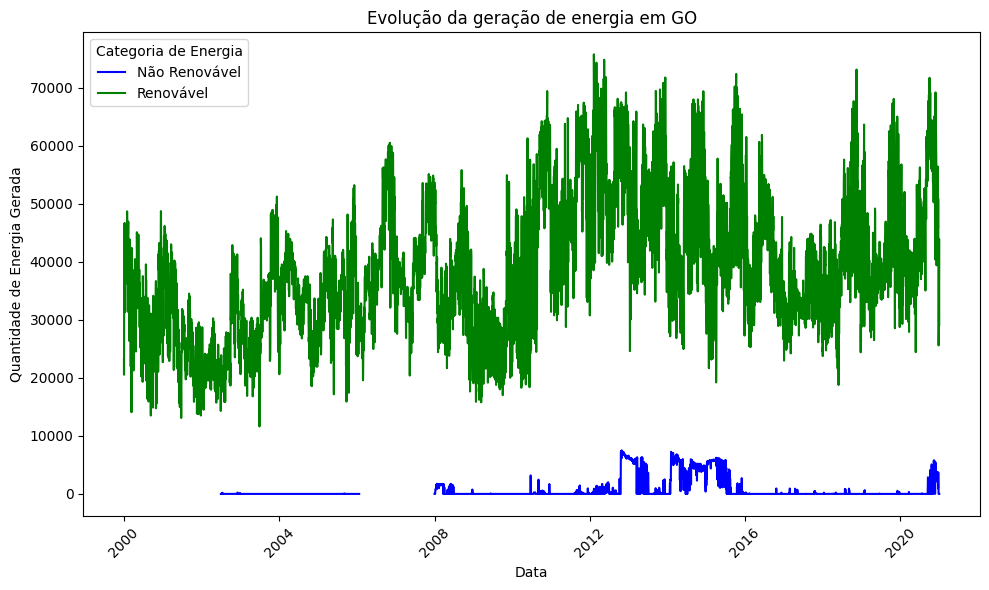

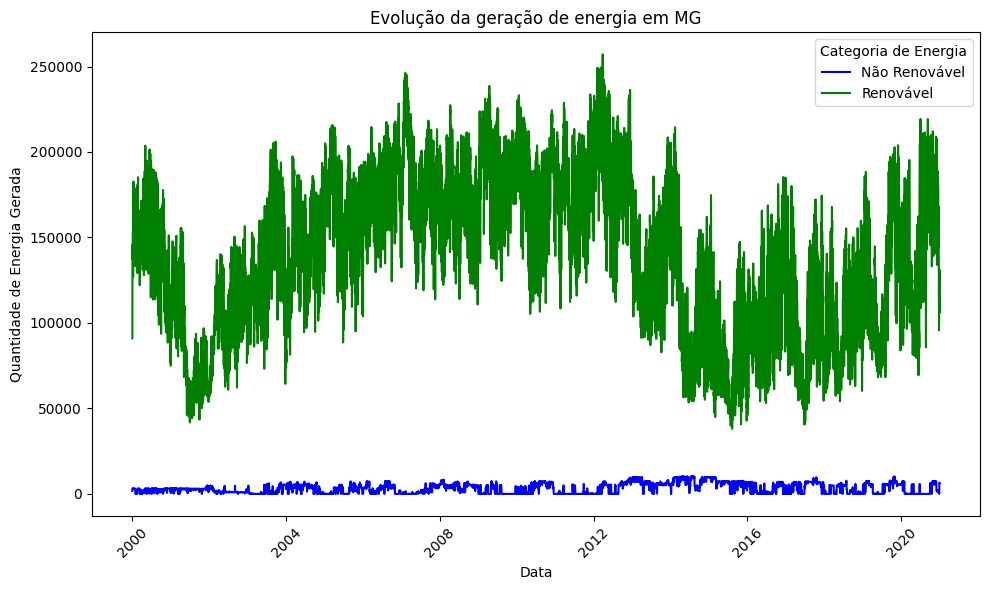

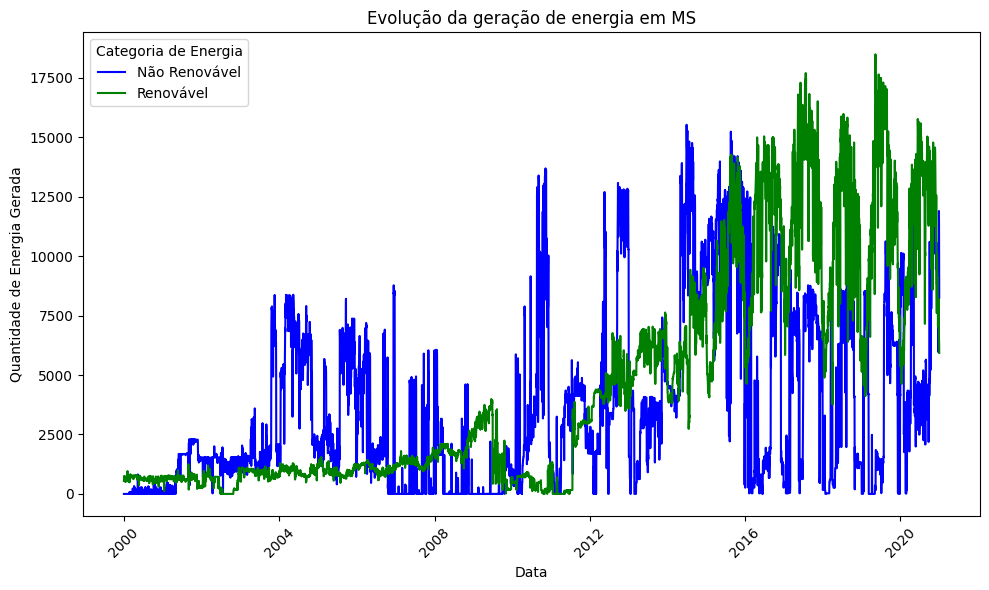

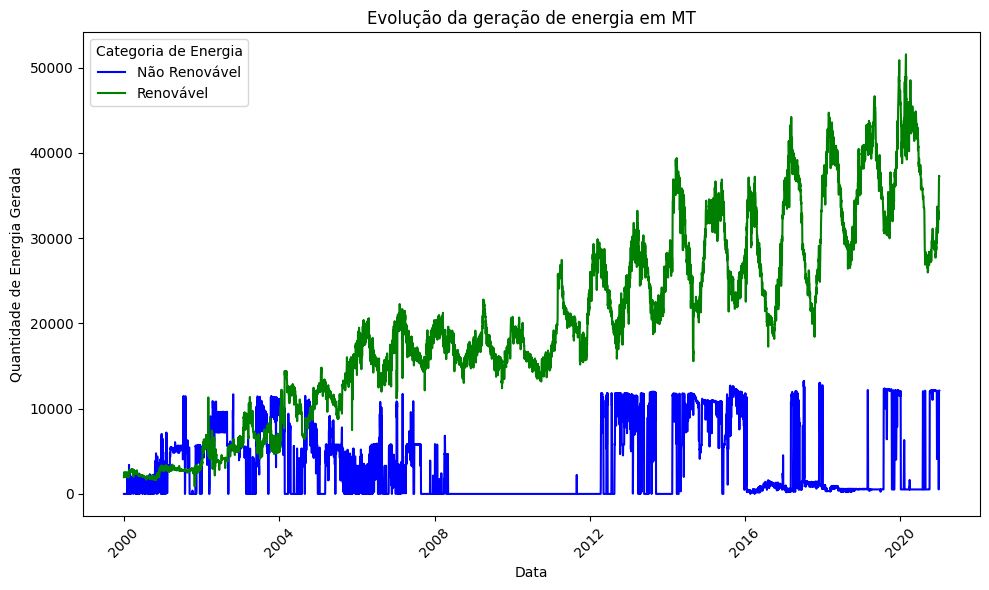

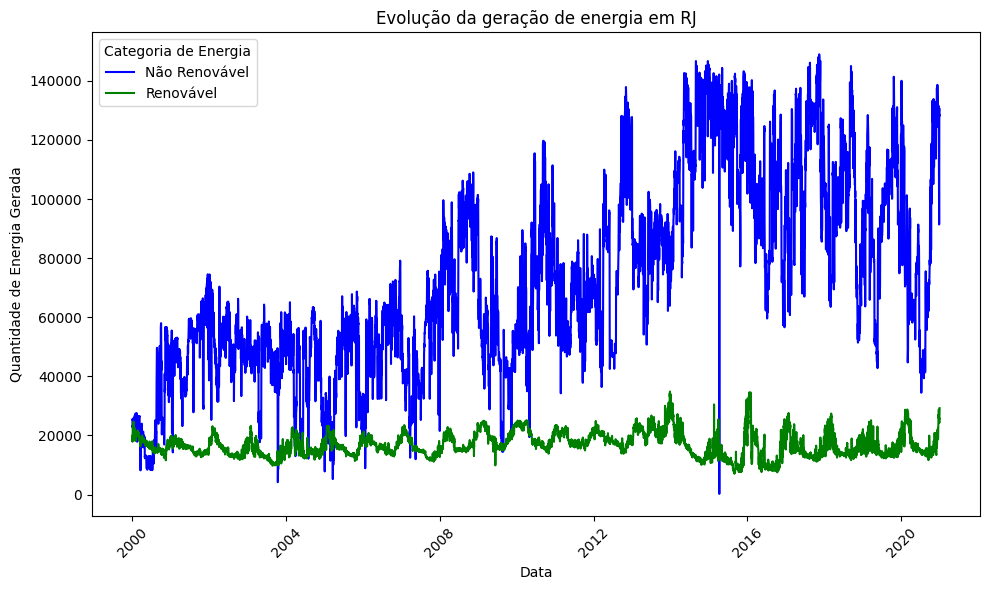

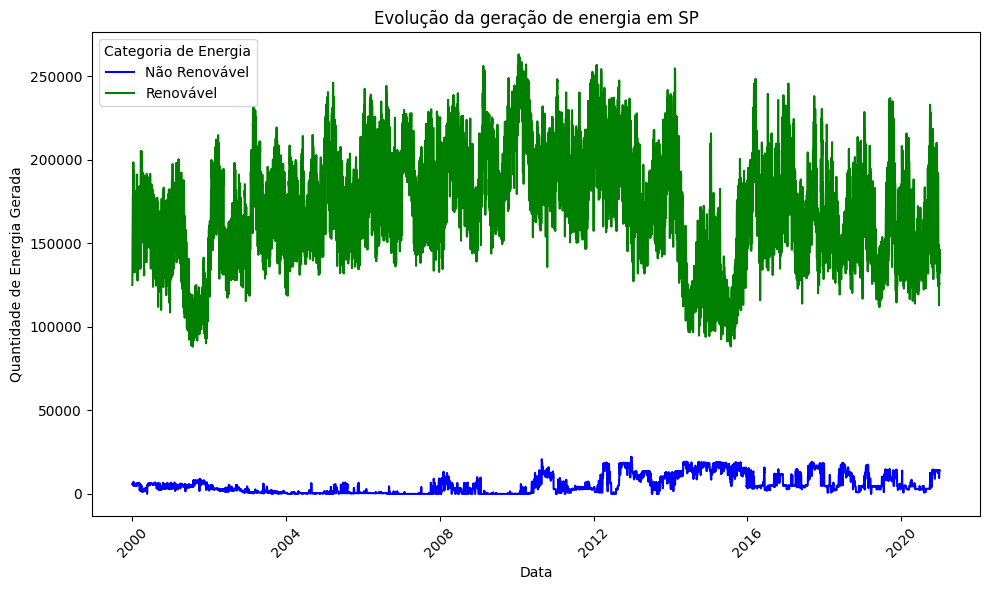

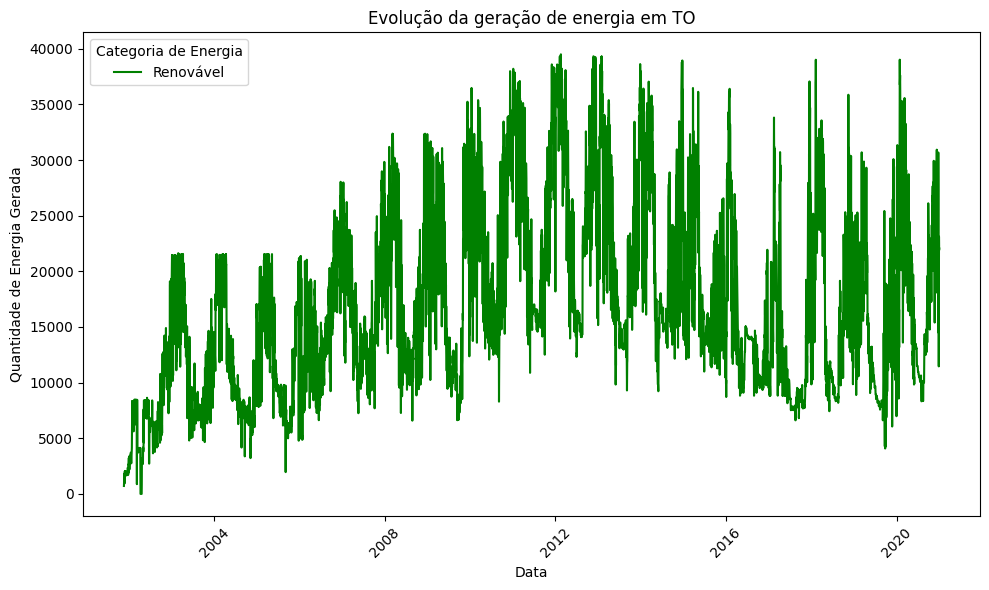

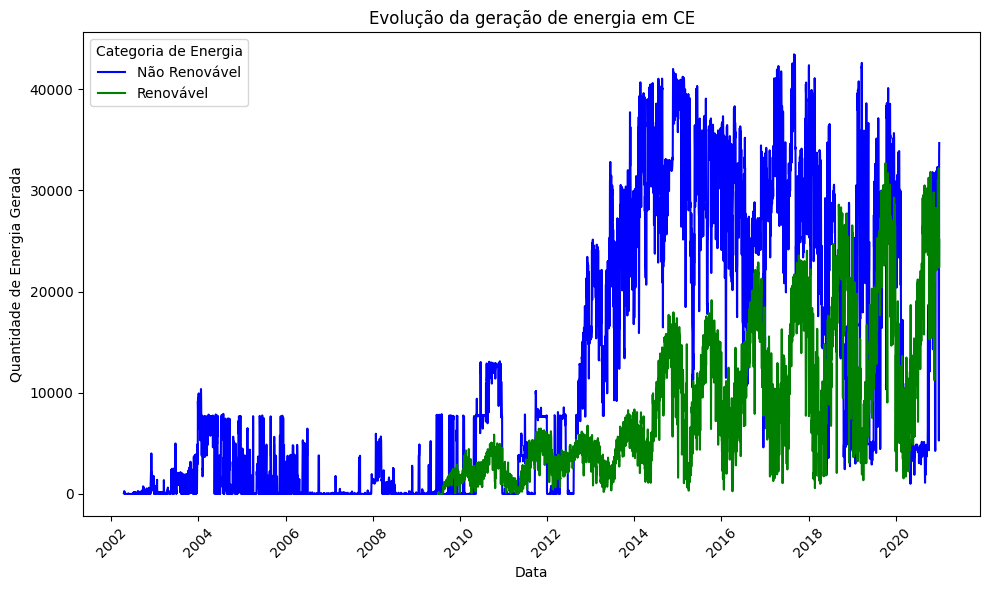

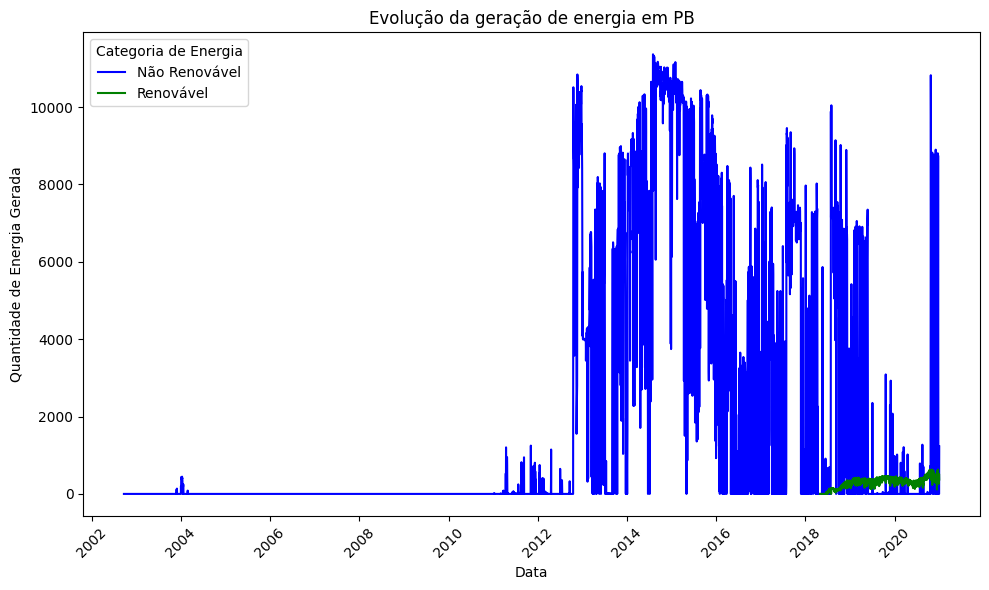

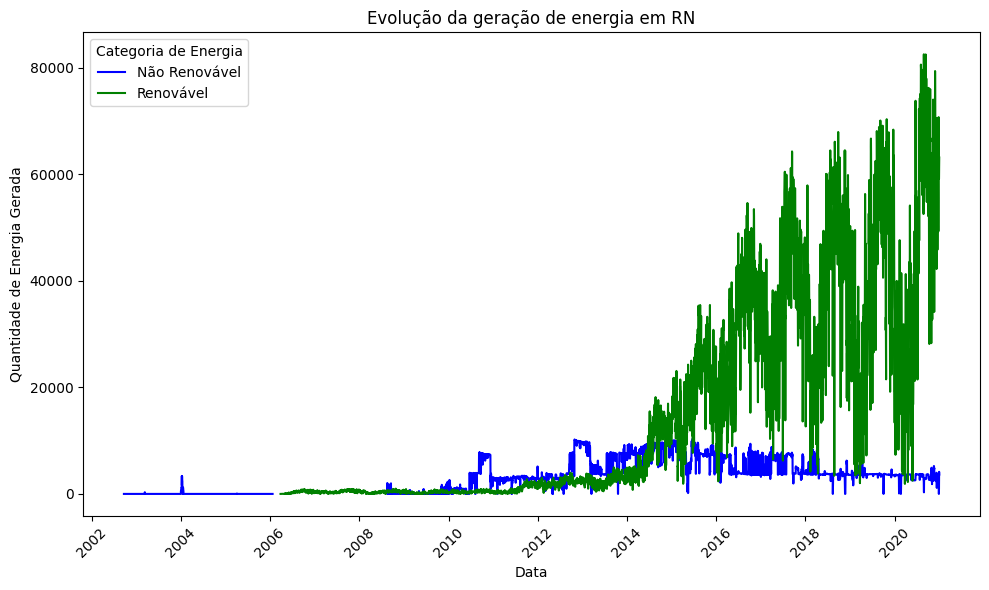

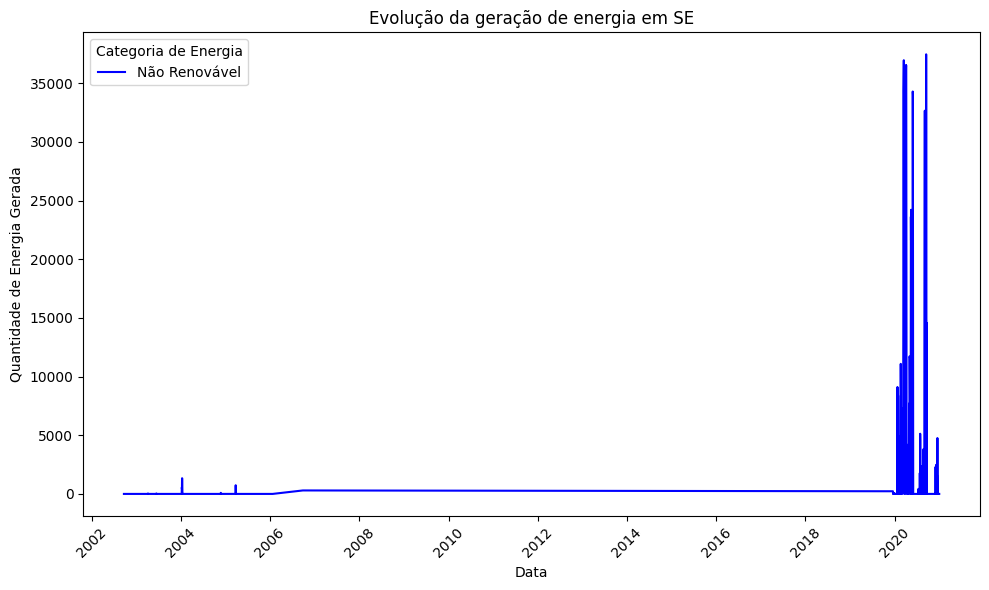

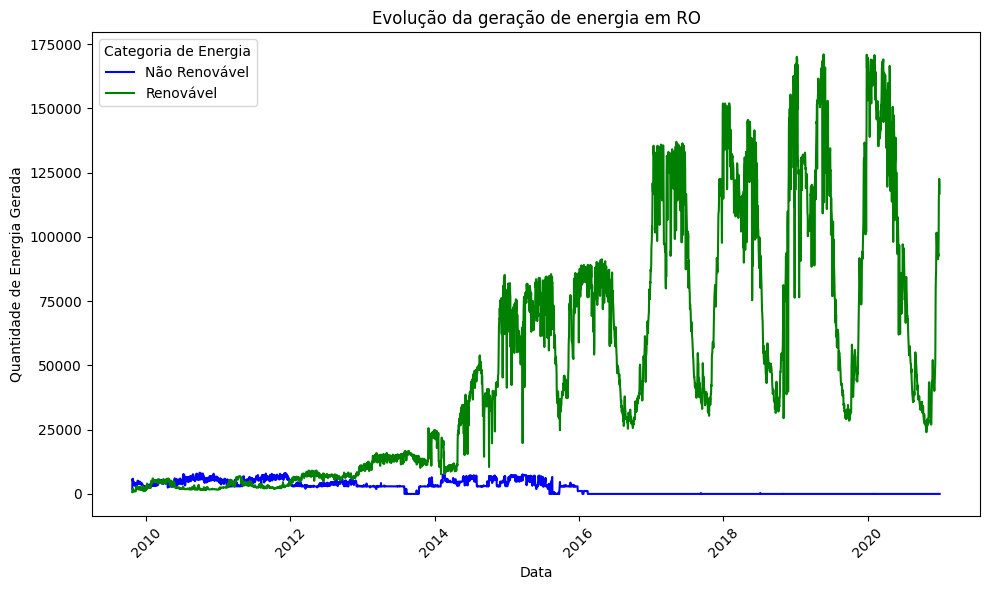

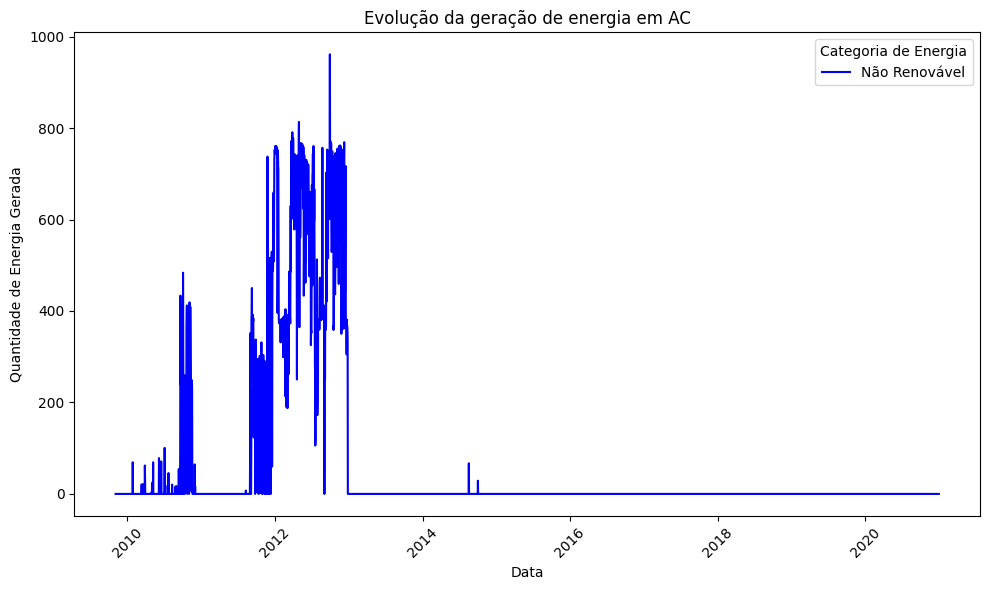

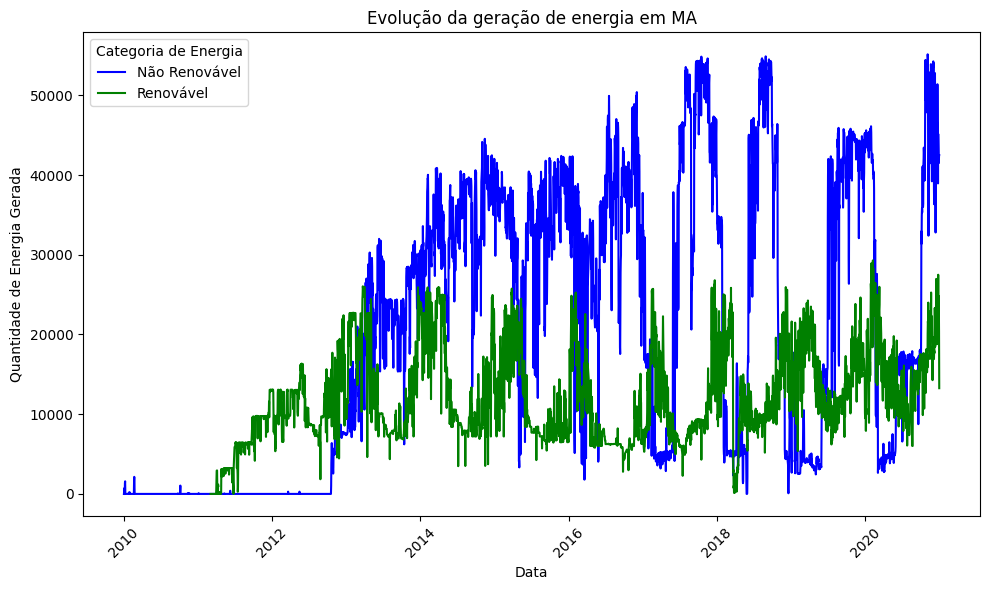

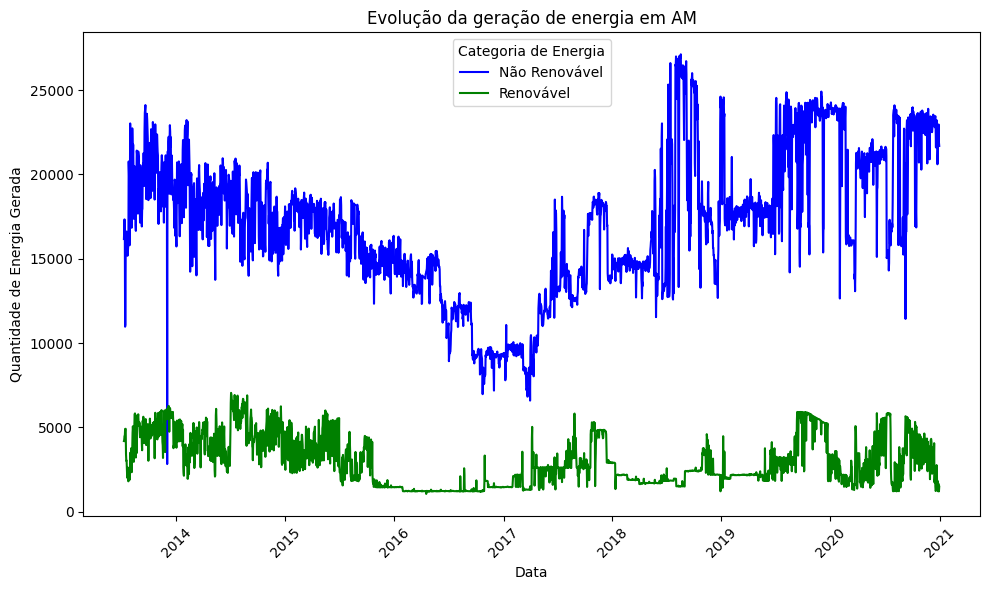

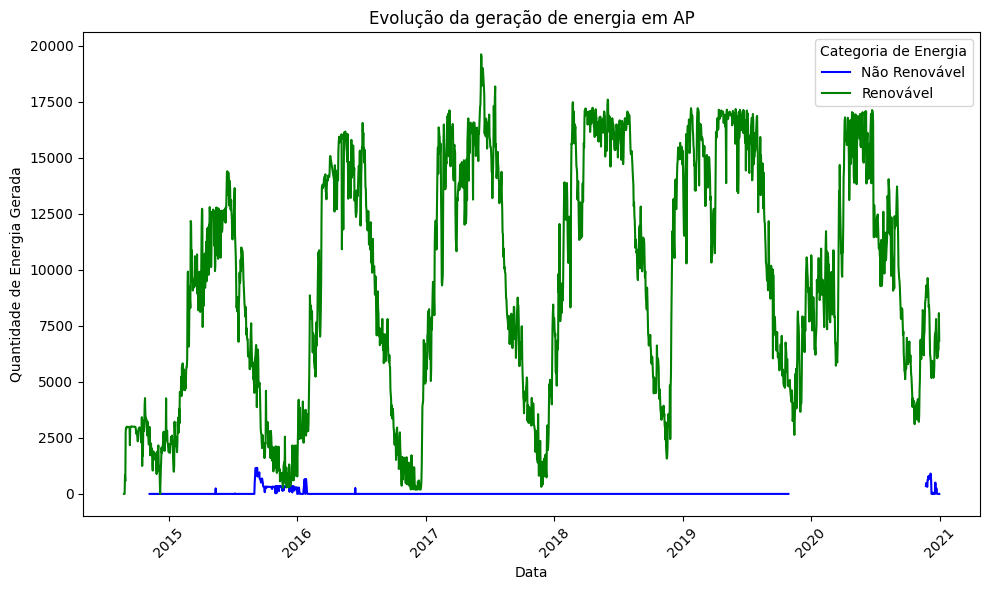

In [ ]:
copia = geracao_final.copy()
categoria_fonte_energia = {
    'Hidráulica': 'Renovável',
    'Biomassa': 'Renovável',
    'Eólica': 'Renovável',
    'Fotovoltaica': 'Renovável',
    'Gás': 'Não Renovável',
    'Carvão': 'Não Renovável',
    'Óleo Combustível': 'Não Renovável',
    'Nuclear': 'Não Renovável',
    'Óleo Diesel': 'Não Renovável',
    'Resíduos Industriais': 'Não Renovável'
}

copia['categoria'] = copia['nom_tipocombustivel'].map(categoria_fonte_energia)

cores = {'Renovável': 'green', 'Não Renovável': 'blue'}

# Loop sobre cada estado
for estado in copia['id_estado'].unique():
    # Filtrar o DataFrame para o estado atual
    df_estado = copia[copia['id_estado'] == estado]

    # Agrupar por categoria e data, somando a quantidade de energia gerada
    df_agrupado = df_estado.groupby([df_estado.index.date, 'categoria'])['val_geracao'].sum().unstack()

    # Plotar o gráfico
    plt.figure(figsize=(10, 6))
    for categoria in df_agrupado.columns:
        plt.plot(df_agrupado.index, df_agrupado[categoria], label=categoria, color=cores[categoria])

    plt.title(f'Evolução da geração de energia em {estado}')
    plt.xlabel('Data')
    plt.ylabel('Quantidade de Energia Gerada')
    plt.xticks(rotation=45)
    plt.legend(title='Categoria de Energia')
    plt.tight_layout()
    plt.show()


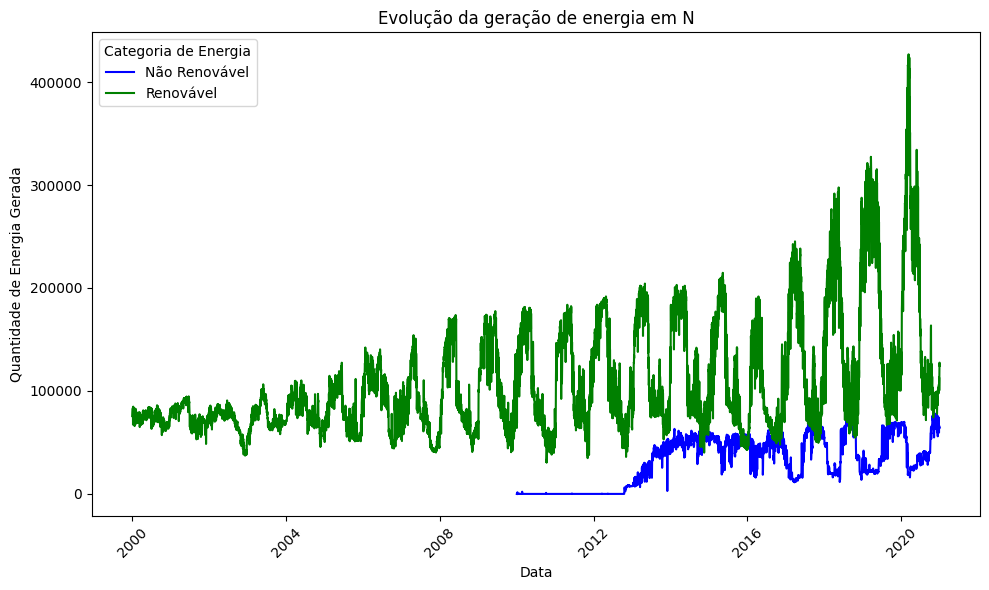

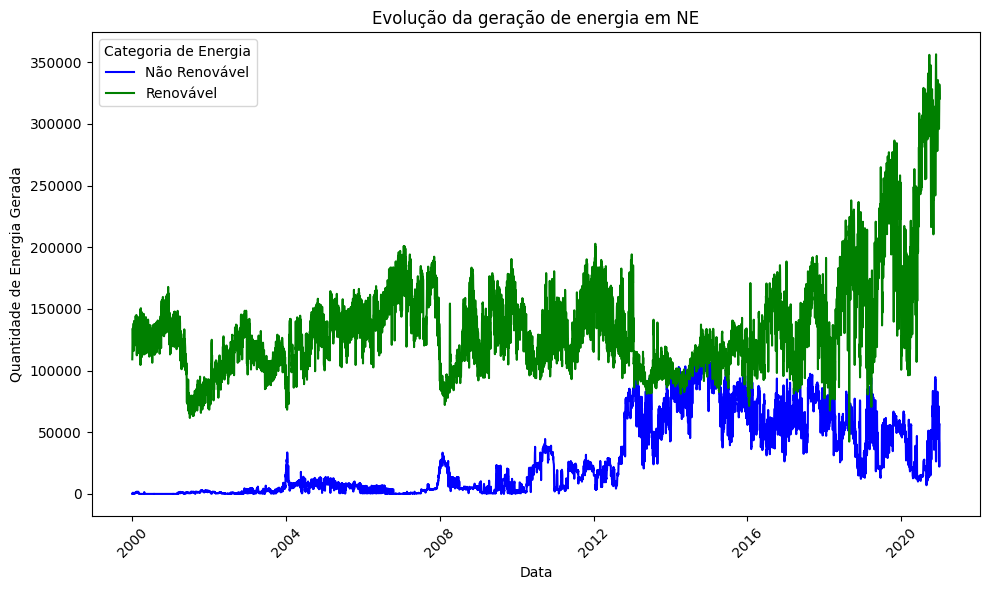

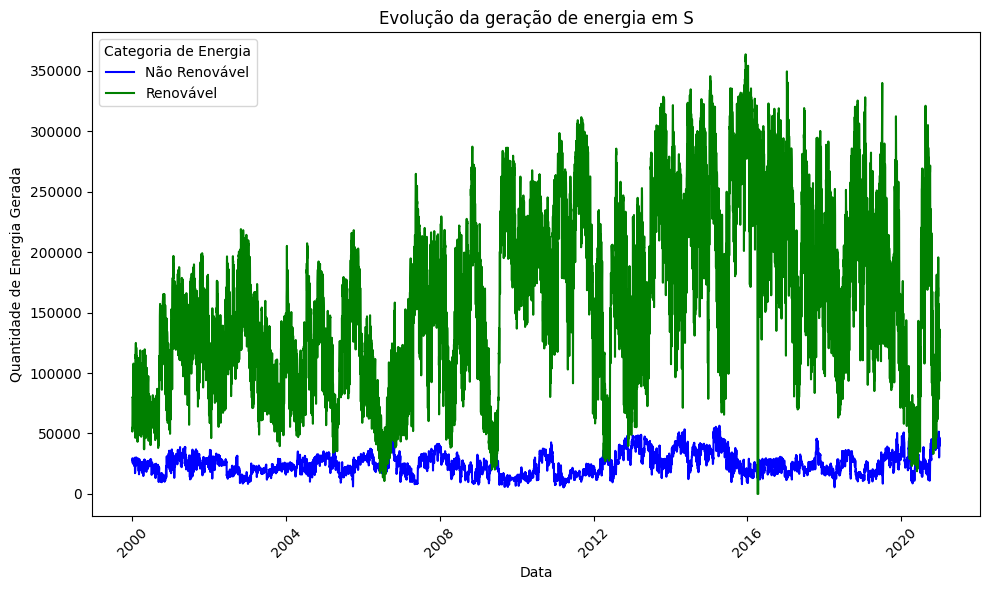

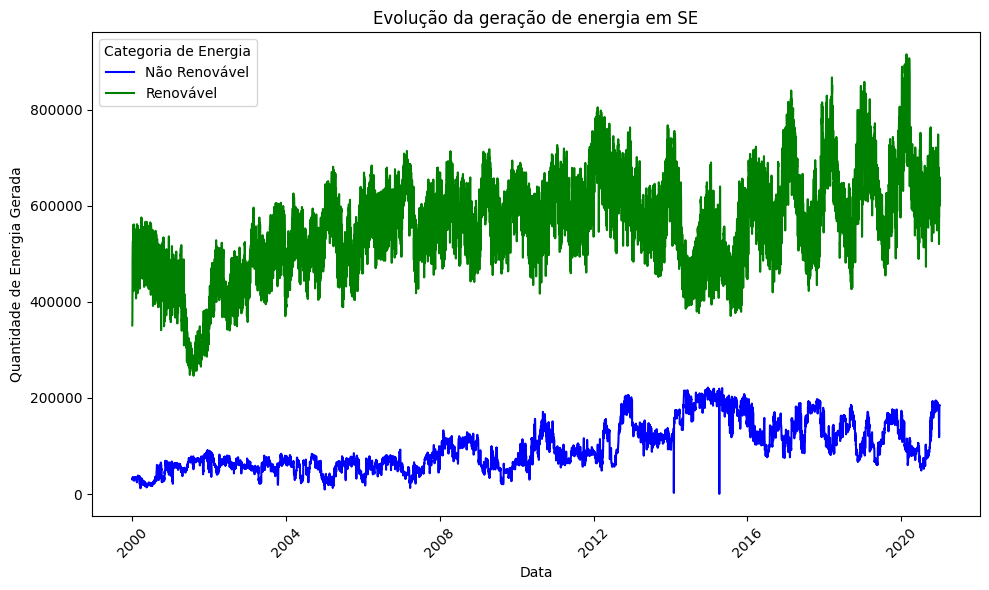

In [ ]:
copia = geracao_final.copy()
categoria_fonte_energia = {
    'Hidráulica': 'Renovável',
    'Biomassa': 'Renovável',
    'Eólica': 'Renovável',
    'Fotovoltaica': 'Renovável',
    'Gás': 'Não Renovável',
    'Carvão': 'Não Renovável',
    'Óleo Combustível': 'Não Renovável',
    'Nuclear': 'Não Renovável',
    'Óleo Diesel': 'Não Renovável',
    'Resíduos Industriais': 'Não Renovável'
}

copia['categoria'] = copia['nom_tipocombustivel'].map(categoria_fonte_energia)

cores = {'Renovável': 'green', 'Não Renovável': 'blue'}

# Loop sobre cada estado
for regiao in copia['id_subsistema'].unique():
    # Filtrar o DataFrame para o estado atual
    df_estado = copia[copia['id_subsistema'] == regiao]

    # Agrupar por categoria e data, somando a quantidade de energia gerada
    df_agrupado = df_estado.groupby([df_estado.index.date, 'categoria'])['val_geracao'].sum().unstack()
    df_agrupado = df_agrupado
    # Plotar o gráfico
    plt.figure(figsize=(10, 6))
    for categoria in df_agrupado.columns:
        plt.plot(df_agrupado.index, df_agrupado[categoria], label=categoria, color=cores[categoria])

    plt.title(f'Evolução da geração de energia em {regiao}')
    plt.xlabel('Data')
    plt.ylabel('Quantidade de Energia Gerada')
    plt.xticks(rotation=45)
    plt.legend(title='Categoria de Energia')
    plt.tight_layout()
    plt.show()


#Série temporal

Filtrando dados de geração hidráulica do estado do Pará, maior produtor de energia hidráulica do país

In [ ]:
df_filtrado = geracao_final.loc[(geracao_final['nom_tipocombustivel'] == 'Hidráulica') & (geracao_final['id_estado'] == 'PA')]
df_filtrado  = df_filtrado.resample('M').mean()

<ipython-input-251-3bd33e723ac6>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_filtrado  = df_filtrado.resample('M').mean()


Plot da série histórica do Pará, com valores mensais de geração de energia

Text(0, 0.5, 'Unidade de medição de energia')

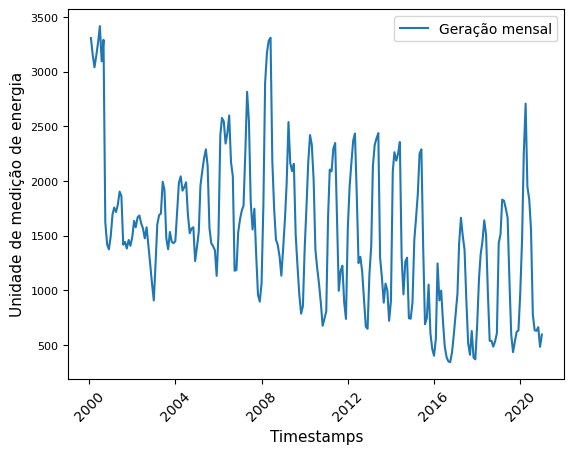

In [ ]:
plt.plot(df_filtrado)
plt.legend(['Geração mensal'],fontsize=10)
plt.xlabel('Timestamps',fontsize=11)
plt.xticks(rotation=45)
plt.yticks(fontsize=8)
plt.ylabel('Unidade de medição de energia',fontsize=11)

In [ ]:
df_filtrado

val_geracao
din_instante             
2000-01-31    3306.385618
2000-02-29    3155.767529
2000-03-31    3039.463844
2000-04-30    3144.691944
2000-05-31    3266.780376
...                   ...
2020-08-31     634.634685
2020-09-30     629.916851
2020-10-31     663.214719
2020-11-30     483.682357
2020-12-31     596.036492

[252 rows x 1 columns]

#Estudo da série

Decomposição da série

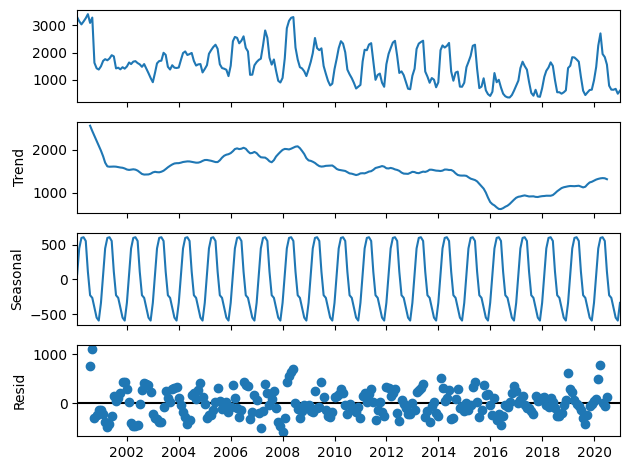

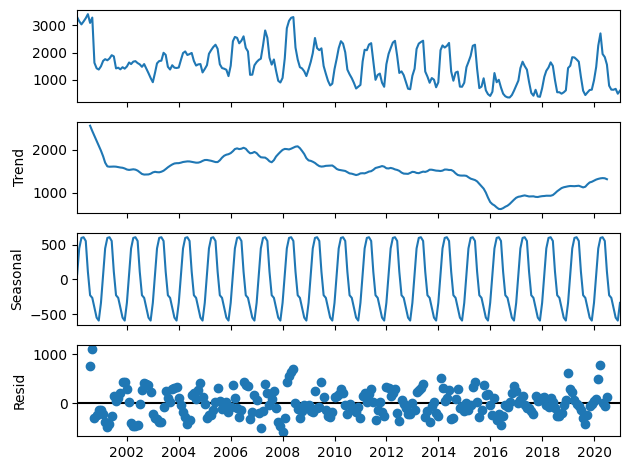

In [ ]:
decompose_result = seasonal_decompose(df_filtrado,model="additive")
decompose_result.plot()

In [ ]:
tendencia = decompose_result.trend
sazonalidade = decompose_result.seasonal
residuo = decompose_result.resid

Estudo das variações de cada mês ao longo dos 20 anos

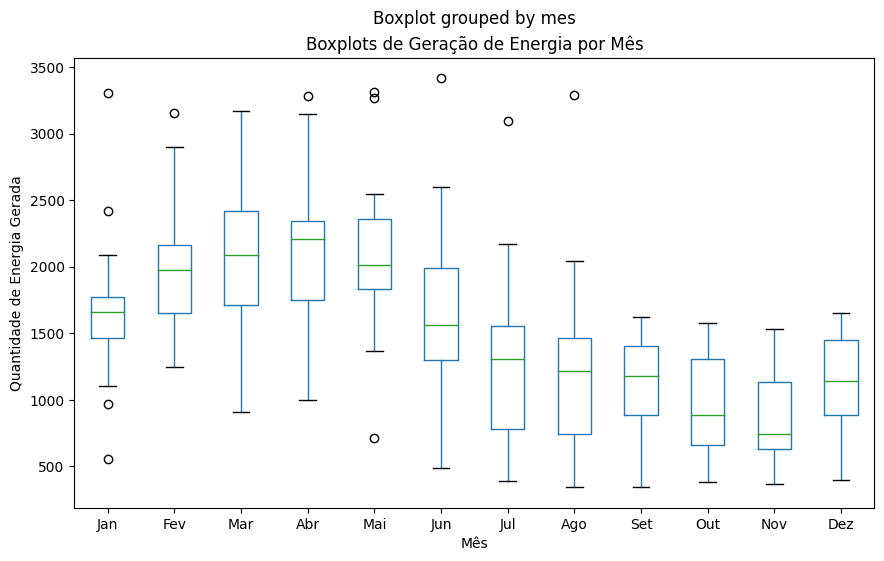

In [ ]:
df_filtrado['mes'] = df_filtrado.index.month
df_filtrado.boxplot(column='val_geracao', by='mes', figsize=(10, 6))

# Configurações adicionais do gráfico
plt.title('Boxplots de Geração de Energia por Mês')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Energia Gerada')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.grid(False)
plt.show()

Dividindo a base em treino (2000-2018) e teste (2019 e 2020)

In [ ]:
data_v = df_filtrado.iloc[:,0].values
x_treino = data_v[:228]
x_test = data_v[228:]

Gráficos de autocorrelação e autocorrelação parcial

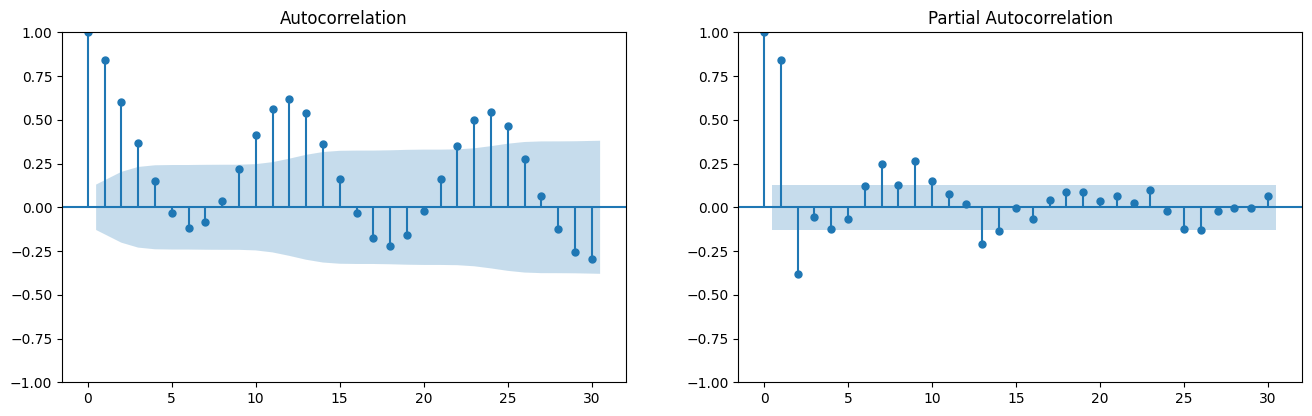

In [ ]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

qtd_lag = 30
acf_pacf(x_treino, qtd_lag)

Teste de estacionariedade da série: caso o teste estatístico da série seja mais negativo que os valores críticos, rejeita-se a hipótese nula e conclui-se que a série é estacionária. Nesse caso, o teste estatístico é menos negativo que os valores críticos, o que indica que a série não é estacionária.

In [ ]:
res=adfuller(df_filtrado.iloc[:,0])
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('Critical Values:')
for key, value in res[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.229460
p-value: 0.195728
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


#Métodos de previsão

Utilizando autoarima para previsão

In [ ]:
xl = x_treino.tolist()
model = pm.auto_arima(x_treino)
predictions=[]
predictions.append(model.predict())
for i in range(len(x_test)-1):
  xl.append(x_test[i])
  model = pm.auto_arima(xl)
  predictions.append(model.predict())

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,3)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "/usr/local/lib/python3.

In [ ]:
predictions = np.array(predictions)
predictions = predictions.T

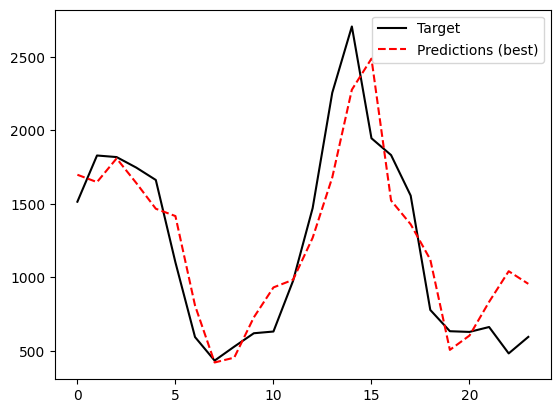

In [ ]:
plt.plot(x_test, color = 'black')
plt.plot(predictions[0], linestyle = '--',color = 'red')
plt.legend(['Target','Predictions (best)'])

In [ ]:
print('Melhor MAPE', MAPE(x_test, predictions[0]))

Melhor MAPE 23.731481694233892


Utilizando um método de regressão linear para fazer a previsão

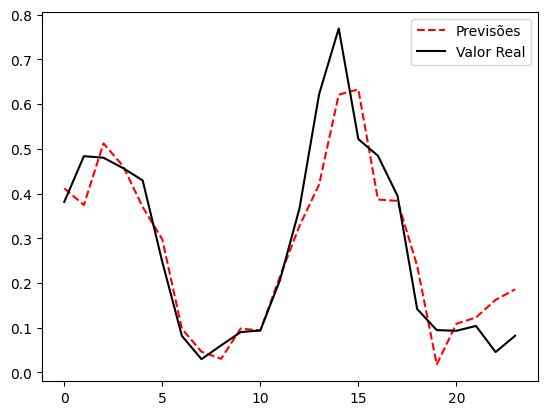

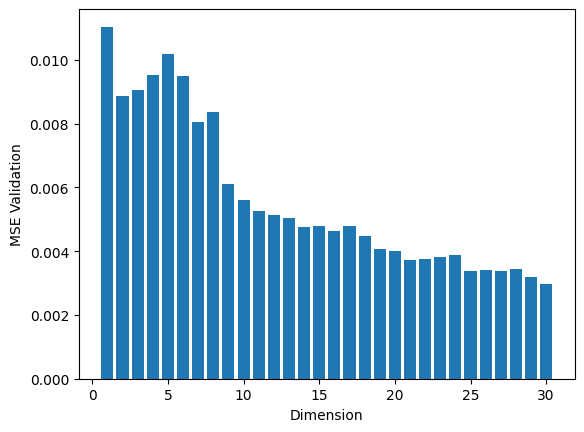

MAPE 41.71433290895245
MSE:  0.006176079958707265


In [ ]:
trainSize = len(x_treino)-24
validSize = 24

maxData = np.max(data_v[0:trainSize])
minData = np.min(data_v[0:trainSize])

ndataset  = (data_v  - minData)/(maxData-minData)


datasetSeries = pd.Series(ndataset)
dimension = 30
stepahead = 1





bestValue = 10**10
model=0
erroBar = []

for dim in range(1,dimension+1,1):

    datasetShifted = pd.concat([datasetSeries.shift(i) for i in range(dim+stepahead) ],axis=1)
    train = (datasetShifted.iloc[dim:trainSize,1:])
    train = np.hstack((train,np.ones_like(train.iloc[:,0].values.reshape(len(train),1))))
    trainTarget = (datasetShifted.iloc[dim:trainSize,0])

    valid = datasetShifted.iloc[trainSize:(validSize+trainSize),1:]
    valid=np.hstack((valid,np.zeros_like(valid.iloc[:,0].values.reshape(len(valid),1))))
    validTarget = datasetShifted.iloc[trainSize:(validSize+trainSize),0]

    test = datasetShifted.iloc[(validSize+trainSize):,1:]
    test= np.hstack((test,np.ones_like(test.iloc[:,0].values.reshape(len(test),1))))
    testTarget = datasetShifted.iloc[(validSize+trainSize):,0]


    X_inv = np.linalg.pinv(train)
    coefs = X_inv.dot(trainTarget)

    predVal = coefs.dot(valid.T)
    erro = mse(predVal,validTarget)

    erroBar.append(erro)
    if(erro<bestValue):
        bestValue=erro
        model=coefs
        test_aux = test
        testTarget_aux = testTarget

predTest = model.dot(test_aux.T)

mse_test = mse(predTest,testTarget_aux)

plt.plot(predTest, linestyle='--', color = 'red')
plt.plot(testTarget_aux.values, color = 'black')
plt.legend(['Previsões','Valor Real'])
plt.show()



plt.bar(range(1,dimension+1,1),erroBar)
plt.xlabel('Dimension')
plt.ylabel('MSE Validation')
plt.show()
print('MAPE', MAPE(predTest,testTarget_aux))
print('MSE: ',mse_test)

Utilizando SRV para fazer a previsão

MSE com seleção: 0.0056275702881394525
MAPE com seleção: 40.04040011259837


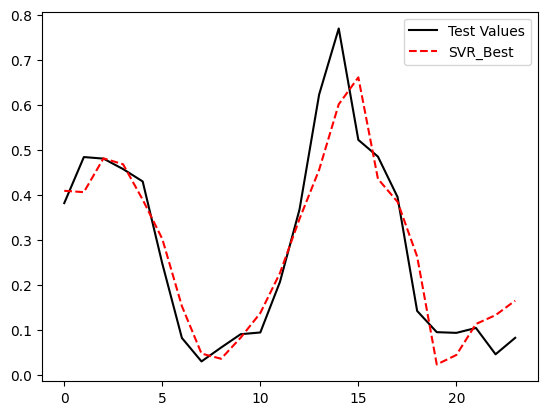

In [ ]:
trainSize = len(x_treino)-24
validSize = 24

maxData = np.max(data_v[0:trainSize])
minData = np.min(data_v[0:trainSize])

ndataset  = (data_v  - minData)/(maxData-minData)


datasetSeries = pd.Series(ndataset)
dimension = 12
stepahead = 1
datasetShifted = pd.concat([datasetSeries.shift(i) for i in range(dimension+stepahead) ],axis=1)

train = (datasetShifted.iloc[dimension:trainSize,1:])
trainTarget = (datasetShifted.iloc[dimension:trainSize,0])

valid = datasetShifted.iloc[trainSize:(validSize+trainSize),1:]
validTarget = datasetShifted.iloc[trainSize:(validSize+trainSize),0]

test = datasetShifted.iloc[(validSize+trainSize):,1:]
testTarget = datasetShifted.iloc[(validSize+trainSize):,0]


#grid manual
g=(10.0)**np.arange(-5,6,1)
e = (10.0)**np.arange(-4,5,1)
c=(10.0)**np.arange(-2,3,1)
bestValue = 10**100000
erroval = []
param=[]
bestSVR=0
for i in g:
    for j in e:
        for k in c:

            mySVR = SVR(C=k,gamma=i,epsilon=j)
            mySVR.fit(train,trainTarget)

            predVals = mySVR.predict(valid)
            erro = mse(predVals,validTarget)
            erroval.append(erro)
            param.append((i,j,k))
            if erro<bestValue:
                bestValue=erro
                bestSVR = mySVR


predTest = bestSVR.predict(test)
mseTest = mse(predTest,testTarget)

SVR_no_Selection = SVR()
SVR_no_Selection.fit(train,trainTarget)
predTestNoSelection = SVR_no_Selection.predict(test)






mseTest_noSelection = mse(predTestNoSelection,testTarget)

plt.plot(testTarget.values, color = 'black')
plt.plot(predTest, linestyle='--',color = 'red')
plt.legend(['Test Values','SVR_Best'])
print('MSE com seleção:', mseTest )
print('MAPE com seleção:', MAPE(predTest,testTarget) )